# KuiSCIMA Experiments

If necessary, install the required packages in `requirements.txt` via `pip`.

Make sure that the cell below loads without error message.

In [1]:
import os
import json
import cv2
from matplotlib import pyplot as plt
import copy
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
from skimage.util import random_noise
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib import cm
import time
import dataclasses
from dataclasses import dataclass
import math
import random
from scipy import stats
import os

# Export Datasets

In [3]:
from extract_dataset_from_corpus import extract_dataset_from_corpus

stem = "../KuiSCIMA/optical_symbolic_dataset"
training_dataset = ["01_lu_edition", "02_zhang_edition", "03_siku_quanshu_edition", "04_zhu_edition"]
test_dataset = ["05_shanghai_manuscript"]

training_dataset = [os.path.join(stem, p) for p in training_dataset]
test_dataset = [os.path.join(stem, p) for p in test_dataset]

output_training = "./TrainingDataset"
output_test = "./TestDataset"
output_total = "./TotalDataset"

try:
    os.mkdir(output_training)
except:
    pass

try:
    os.mkdir(output_test)
except:
    pass

try:
    os.mkdir(output_total)
except:
    pass

extract_dataset_from_corpus(training_dataset, output_training)
extract_dataset_from_corpus(test_dataset, output_test)
extract_dataset_from_corpus(stem, output_total)

In [4]:
# Set seeds

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# Data Augmentations for Training

In [5]:
def shrink(is_random=True):
    def inner(input_image):
         
        t_size = random.randint(15, 22) if is_random else 20
        
        original_width = input_image.shape[-1]
        original_height = input_image.shape[-2]
        aspect_ratio = original_width / original_height * random.uniform(0.6, 1.5) if is_random else original_width / original_height
        
        if aspect_ratio > 1:
            w = int(t_size)
            h = int(t_size / aspect_ratio)
        else: 
            w = int(t_size * aspect_ratio)
            h = int(t_size)

        output_image = transforms.Resize(size=(h, w), interpolation=transforms.InterpolationMode.NEAREST_EXACT)(input_image)
        return output_image
    
    return inner

def paste_to_square(is_random=True, target_size=28):
    def inner(input_image):
        ## Modify the function to extend the
        ## input image to a square of 40x40.
        ## Tip: This can be done by clever use
        ## of the Pad function
        ## https://pytorch.org/vision/stable/generated/torchvision.transforms.Pad.html
        ## Also make sure that the added padding
        ## on each side is random, i.e., the 
        ## data itself is augmented by its
        ## position in the square.
                
        pad_width = target_size - input_image.shape[-1]
        pad_height = target_size - input_image.shape[-2]
        
        left_pad = random.randint(0, pad_width) if is_random else pad_width//2
        top_pad = random.randint(0, pad_height) if is_random else pad_height//2
        
        right_pad = pad_width - left_pad
        bottom_pad = pad_height - top_pad
            
        output_image = transforms.Pad(padding=(left_pad, top_pad, right_pad, bottom_pad), fill=1)(input_image) 
        return output_image
    
    return inner

def salt_and_pepper(percentage=0.1):
    def inner(input_image):
        output_image = input_image.numpy().squeeze()
        if random.uniform(0, 1) < percentage/2:
            amount = 0.02
            output_image = random_noise(output_image, mode='salt', amount=amount)
        if random.uniform(0, 1) < percentage/2:
            amount = 0.01
            output_image = random_noise(output_image, mode='pepper', amount=amount)
        return torch.Tensor(output_image).unsqueeze(0)
    return inner

def erode(percentage=0.1):
    def inner(input_image):
        if random.uniform(0, 1) < percentage:  # only apply transformation according to percentage
            kernel = np.ones((2,2),np.uint8)
            output_image = cv2.erode(input_image, kernel, iterations=1)
            return output_image
        else:
            return input_image
    return inner

def dilate(percentage=0.1):
    def inner(input_image):
        if random.uniform(0, 1) < percentage:  # only apply transformation according to percentage
            kernel = np.ones((2,2),np.uint8)
            output_image = cv2.dilate(input_image, kernel, iterations=1)
            return output_image
        else:
            return input_image
    return inner

## Normalizes the dataset to have mean 0 and standard deviation of 1
## --> good for later model performance
#mean_list = torch.Tensor([torch.Tensor(entry["image"]).mean() for entry in dataset])/255
#mean = mean_list.mean()
#std = mean_list.std()

def normalize():
    return transforms.Normalize(mean=0.7102, std=0.0914)

# Dataset and Dataloader functions

In [6]:
class_to_annotation =  {
            "pitch": {0: "HE", 1: "SI", 2: "YI", 3: "SHANG", 4: "GOU", 5: "CHE", 6: "GONG", 7: "FAN", 8: "LIU", 9: "WU", 10: "GAO_WU"},
            "secondary": {0: None, 1: "DA_DUN", 2: "XIAO_ZHU", 3: "DING_ZHU", 4: "DA_ZHU", 5: "ZHE", 6: "YE"}
}

annotation_to_class = {
    "pitch": {"HE": 0, "SI": 1, "YI": 2, "SHANG": 3, "GOU": 4, "CHE": 5, "GONG": 6, "FAN": 7, "LIU": 8, "WU": 9, "GAO_WU": 10},
    "secondary": {None: 0, "DA_DUN": 1, "XIAO_ZHU": 2, "DING_ZHU": 3, "DA_ZHU": 4, "ZHE": 5, "YE": 6}
}

## this function takes the path_to_folder (i.e., the folder where the dataset.json is in)
## and returns a list of the dataset entries. Each entry consists of the keys:
##     "image_path": 
##     "type": The type of the box (in our case, this is 'Music' only)
##     "annotation": The annotation string
##     "image": The image as uint8 array representation
##     "is_simple": This is True if the notation is "simple notation" as opposed to "composite notation"
def open_dataset(path_to_folder):
    path_to_json = os.path.join(path_to_folder, "dataset.json")
    with open(path_to_json) as file:
        dataset_json = json.load(file)
        output_list = []
        
        for idx in range(len(dataset_json)):
            if dataset_json[idx]["annotation"]["pitch"] is None or dataset_json[idx]["annotation"]["pitch"] == "None":
                continue
            temp_dict = {}
            temp_dict["image"] = cv2.imread(os.path.join(path_to_folder, dataset_json[idx]["image_path"]), cv2.IMREAD_GRAYSCALE)
            temp_dict["is_simple"] = True if dataset_json[idx]["annotation"]["secondary"] == None else False
            temp_dict["annotation"] = {}
            temp_dict["annotation"]["pitch"] = annotation_to_class["pitch"][dataset_json[idx]["annotation"]["pitch"]]
            temp_dict["annotation"]["secondary"] = annotation_to_class["secondary"][dataset_json[idx]["annotation"]["secondary"]]
            temp_dict["edition"] = os.path.basename(dataset_json[idx]["image_path"]).split("_")[0]
            temp_dict["image_id"] = "_".join(dataset_json[idx]["image_path"].split("_")[:-1])
            temp_dict["image_path"] = os.path.basename(dataset_json[idx]["image_path"])
            output_list.append(temp_dict)
    return output_list

def get_cropped_dataset(dataset):  ## creates a new dataset where each of the images is cropped
    
    def remove_small_blobs(image):  # remove small isolated connected black areas
        noise_removal_threshold = 1  
        mask = np.ones_like(image)*255
        contours, hierarchy = cv2.findContours(255-image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        for contour in contours:
          area = cv2.contourArea(contour)
          if area >= noise_removal_threshold:
            cv2.fillPoly(mask, [contour], 0)
        return mask


    def crop_excess_whitespace(image):
        gray = 255*(image < 128).astype(np.uint8) #reverse the colors
        coords = cv2.findNonZero(gray) # Find all non-zero points (text)
        x, y, w, h = cv2.boundingRect(coords) # Find minimum spanning bounding box
        rect = image[y:y+h, x:x+w]
        return rect

    cropped_dataset = copy.deepcopy(dataset)
    for idx in range(len(cropped_dataset)):
        cropped_dataset[idx]["image"] = crop_excess_whitespace(remove_small_blobs(dataset[idx]["image"]))
    return cropped_dataset

train_transforms = transforms.Compose([
    erode(percentage=0.1), # causes the notation to be thicker
    dilate(percentage=0.1), # causes the notation to be thinner
    transforms.ToTensor(), # convert from uint8 to [0, 1]
    shrink(is_random=True),
    paste_to_square(is_random=False),
    salt_and_pepper(percentage=0.8), # introduces salt-and-pepper-noise
    lambda img: transforms.functional.invert(img), # inverts image, needed for rotations
    transforms.RandomRotation(degrees=(-8, 8)), # randomly rotate between -12 and 12 degrees
    #lambda img: transforms.functional.invert(img), # inverts image to original color scheme
    normalize(), # normalize mean and variance
])

validation_transforms = transforms.Compose([
    transforms.ToTensor(),
    shrink(is_random=False),
    paste_to_square(is_random=False),
    lambda img: transforms.functional.invert(img), # inverts image, needed for rotations
    normalize(), # normalize mean and variance
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    shrink(is_random=False),
    paste_to_square(is_random=False),
    lambda img: transforms.functional.invert(img), # inverts image, needed for rotations
    normalize(), # normalize mean and variance
])


@dataclass
class ValidationEditions:  # This parameter chooses which edition is used for validation. The other editions are for training.
    NONE: str = "none"
    LU: str = "lu"
    ZHANG: str = "zhang"
    SIKU: str = "siku"
    ZHU: str = "zhu"

@dataclass
class LabelType:
    #PITCH: str = "pitch"
    PITCH_BALANCED: str = "pitch_balanced"
    #SECONDARY: str = "secondary"
    SECONDARY_BALANCED: str = "secondary_balanced"

class Dataset(torch.utils.data.Dataset):
    def __init__(self, label_type, dataset: list, transform=None):
        self.X = [entry["image"] for entry in dataset]

        if label_type.split("_")[0] == "pitch":
            self.y = [entry["annotation"]["pitch"] for entry in dataset]
        else:
            self.y = [entry["annotation"]["secondary"] for entry in dataset]

        self.is_simple = [entry["is_simple"] for entry in dataset]


        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        sample = self.X[idx]
        if self.transform:
            sample = self.transform(sample)
        label = self.y[idx]
        is_simple = self.is_simple[idx]
        return sample, label, is_simple
            
def get_dataloaders(dataset, validation_edition=ValidationEditions.NONE, label_type=LabelType.PITCH_BALANCED, is_test_loader=False):
    def get_datasets():
        if validation_edition is not ValidationEditions.NONE:
            train_data = Dataset(label_type, [entry for entry in dataset if entry["edition"]!=validation_edition], transform=train_transforms)
            validation_data = Dataset(label_type, [entry for entry in dataset if entry["edition"]==validation_edition], transform=validation_transforms)
            test_data = Dataset(label_type, [entry for entry in dataset if entry["edition"]==validation_edition], transform=test_transforms)
        else:
            # random shuffling the data
            indices = [i for i in range(len(dataset))]
            np.random.shuffle(indices)
            split = int(len(dataset) * 0.8) # 80% of data
            train_data = Dataset(label_type, dataset[:split], transform=train_transforms)
            validation_data = Dataset(label_type, dataset[split:], transform=validation_transforms)
            test_data = Dataset(label_type, dataset[split:], transform=test_transforms)
        return train_data, validation_data, test_data
    
    def get_dataloaders(train_data, validation_data, test_data):
        def get_sampler(y):
            inverse_class_weights = 1/np.unique(y, return_counts=True)[1]
            inverse_weigths = [inverse_class_weights[int(label)] for label in y]
                
            return torch.utils.data.WeightedRandomSampler(weights=inverse_weigths, num_samples=60000, replacement=True)

        def get_val_sampler(y):
            inverse_class_weights = 1/np.unique(y, return_counts=True)[1]
            inverse_weigths = [inverse_class_weights[int(label)] for label in y]
                
            return torch.utils.data.WeightedRandomSampler(weights=inverse_weigths, num_samples=len(y), replacement=True)
        
        sample = "balanced" in label_type
                    
        train_sampler = get_sampler(train_data.y) if sample else None
        validation_sampler = get_val_sampler(validation_data.y) if sample else None

        loaders = {
            'train' : torch.utils.data.DataLoader(train_data, 
                                                  batch_size=100, 
                                                  sampler=train_sampler),

            'validation'  : torch.utils.data.DataLoader(validation_data, 
                                                  batch_size=100, 
                                                  sampler=validation_sampler),
            'test'  : torch.utils.data.DataLoader(test_data, 
                                                  batch_size=100),
        }
        
        return loaders
    
    train_data, validation_data, test_data = get_datasets()
    

    return get_dataloaders(train_data, validation_data, test_data)

def get_all_dataloaders(dataset):
    dataloader_dict = {}
    for val_edition in dataclasses.astuple(ValidationEditions()):
        dataloader_dict[val_edition] = {}
        for label_type in dataclasses.astuple(LabelType()):
            dataloader_dict[val_edition][label_type] = get_dataloaders(dataset, val_edition, label_type)
    return dataloader_dict

def get_test_dataloaders(dataset):
    return {
        LabelType.PITCH_BALANCED: torch.utils.data.DataLoader(Dataset(LabelType.PITCH_BALANCED, dataset, transform=test_transforms), batch_size=100),
        LabelType.SECONDARY_BALANCED: torch.utils.data.DataLoader(Dataset(LabelType.SECONDARY_BALANCED, dataset, transform=test_transforms), batch_size=100)
    }

def visualize_dataloader(dl, to_string=None):
    figure = plt.figure(figsize=(10, 8))
    cols, rows = 5, 5
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(dl.dataset), size=(1,)).item()
        img, label, _ = dl.dataset[sample_idx]
        figure.add_subplot(rows, cols, i)
        
        if to_string is not None:
            label = class_to_annotation[to_string][label]
            
        plt.title(label)
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
    plt.show()

# Load Data and Make Visualization

In [7]:
orig_dataset = open_dataset("./TrainingDataset/Music/")
dataset = get_cropped_dataset(orig_dataset)
dataloaders = get_all_dataloaders(dataset)

test_dataset = open_dataset("./TestDataset/Music/")
test_dataset = get_cropped_dataset(test_dataset)
test_dataloaders = get_test_dataloaders(test_dataset)

total_dataset = open_dataset("./TotalDataset/Music/")
total_dataset = get_cropped_dataset(total_dataset)
total_dataloaders = get_test_dataloaders(total_dataset)

In [8]:
per_edition = {}

for instance in total_dataset:
    try:
        #print(len(per_edition[instance["edition"]]))
        if len(per_edition[instance["edition"]]) < 5:
            per_edition[instance["edition"]].append(instance["image"])
    except KeyError:
        per_edition[instance["edition"]] = [instance["image"]]
        
print(per_edition.keys())

dict_keys(['lu', 'zhang', 'siku', 'zhu', 'shanghai'])


/tmp/ipykernel_11365/3291701621.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


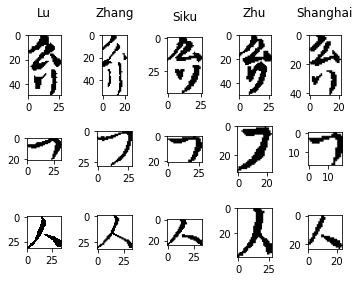

In [9]:
# style visualization

start_idx = 0

rows, cols = 3, len(per_edition.keys())
fig, axs = plt.subplots(rows, cols, figsize=(5, 4))
fig.tight_layout()
#fig.suptitle('Horizontally stacked subplots')
for row in range(rows):
    for col in range(cols):
        edition = list(per_edition.keys())[col]
        if row == 0:
            axs[0][col].set_title(edition.capitalize(), fontsize=12, y=1.2)

        axs[row][col].imshow(per_edition[edition][row], cmap="gray")
        
    
fig.show()
fig.tight_layout()
fig.savefig("styles.pdf", format="pdf", bbox_inches="tight")

/tmp/ipykernel_103966/4009716966.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


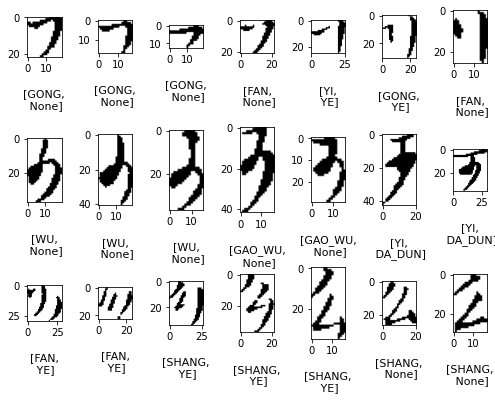

In [325]:
# Ambiguous notations

start_idx = 0

def find_in_dataset(image_path):
    for instance in test_dataset:
        if image_path in instance["image_path"]:
            return instance

examples = [
    [find_in_dataset("shanghai_manuscript_035_44"), find_in_dataset("shanghai_manuscript_035_19"), test_dataset[-10], test_dataset[-45], test_dataset[-13], test_dataset[274], find_in_dataset("shanghai_manuscript_045_73")],
    [test_dataset[8], find_in_dataset("shanghai_manuscript_045_53"), test_dataset[32], find_in_dataset("shanghai_manuscript_089_56"), find_in_dataset("shanghai_manuscript_089_23"), find_in_dataset("shanghai_manuscript_074_164"), find_in_dataset("shanghai_manuscript_089_101")],
    [find_in_dataset("shanghai_manuscript_089_55"), find_in_dataset("shanghai_manuscript_089_39"), find_in_dataset("shanghai_manuscript_076_90"), find_in_dataset("shanghai_manuscript_077_77"), find_in_dataset("shanghai_manuscript_045_51"), find_in_dataset("shanghai_manuscript_076_81"), find_in_dataset("shanghai_manuscript_043_78")],
]

cols, rows = len(examples[0]), len(examples)
fig, axs = plt.subplots(rows, cols, figsize=(7, 6))
fig.tight_layout()
#fig.suptitle('Horizontally stacked subplots')
for row in range(rows):
    #if row == 0:
    #    axs[0][cols//2].set_title("Original", fontsize=16, y=1.4)
    #    axs[1][cols//2].set_title("Validation/Test Transform", fontsize=16, y=1.1)
    
    for col in range(cols):
        instance = examples[row][col]
        axs[row][col].imshow(instance["image"], cmap="gray")
        primary = class_to_annotation["pitch"][instance["annotation"]["pitch"]]
        secondary = class_to_annotation["secondary"][instance["annotation"]["secondary"]]
        axs[row][col].set_xlabel(f'\n[{primary},\n {secondary}]', size=11)
    
fig.show()
fig.tight_layout()
fig.savefig("ambiguous_notations.pdf", format="pdf", bbox_inches="tight")

/tmp/ipykernel_103966/2403132182.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


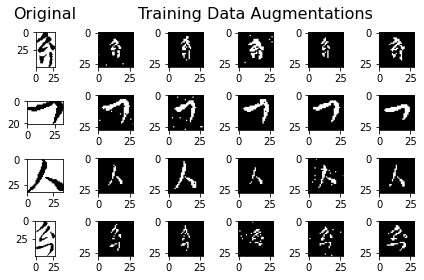

In [374]:
# take a sample and visualize some data augmentations

start_idx = 0

rows, cols = 4, 6
fig, axs = plt.subplots(rows, cols)
fig.tight_layout()
#fig.suptitle('Horizontally stacked subplots')
for row in range(rows):
    if row == 0:
        axs[0][0].set_title("Original", fontsize=16, y=1.2)
        axs[0][3].set_title("Training Data Augmentations", fontsize=16, y=1.2)
    
    axs[row][0].imshow(orig_dataset[start_idx+row]["image"], cmap="gray")
        
    for col in range(cols-1):
        col += 1
        axs[row][col].imshow(train_transforms(dataset[start_idx+row]["image"])[0], cmap="gray")
fig.show()
fig.tight_layout()
fig.savefig("training_data_augmentations.pdf", format="pdf", bbox_inches="tight")

/tmp/ipykernel_103966/3780373263.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


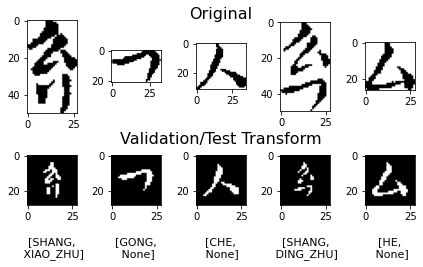

In [182]:
# take a sample and visualize some data augmentations
start_idx = 0

rows, cols = 2, 5
fig, axs = plt.subplots(rows, cols)
fig.tight_layout()
#fig.suptitle('Horizontally stacked subplots')
for row in range(rows):
    if row == 0:
        axs[0][cols//2].set_title("Original", fontsize=16, y=1.4)
        axs[1][cols//2].set_title("Validation/Test Transform", fontsize=16, y=1.1)
    
    for col in range(cols):
        axs[0][col].imshow(orig_dataset[start_idx+col]["image"], cmap="gray")
        axs[1][col].imshow(validation_transforms(orig_dataset[start_idx+col]["image"])[0], cmap="gray")
        primary = class_to_annotation["pitch"][orig_dataset[start_idx+col]["annotation"]["pitch"]]
        secondary = class_to_annotation["secondary"][orig_dataset[start_idx+col]["annotation"]["secondary"]]
        axs[1][col].set_xlabel(f'\n[{primary},\n {secondary}]', size=11)

        
fig.show()
fig.tight_layout()
fig.savefig("validation_data_augmentations.pdf", format="pdf", bbox_inches="tight")

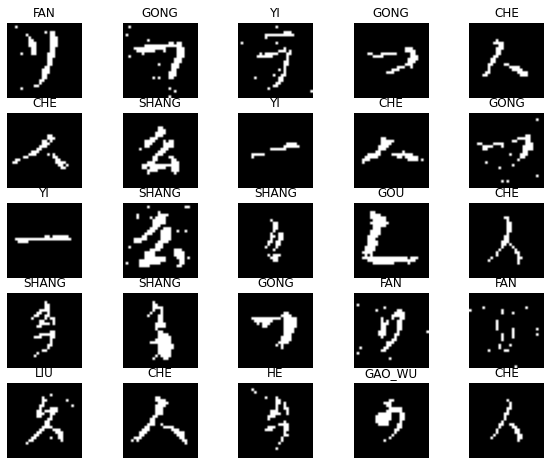

In [100]:
# visualize pitch training data (Lu edition is excluded from training data)
visualize_dataloader(dataloaders[ValidationEditions.NONE][LabelType.PITCH_BALANCED]["train"], to_string="pitch")

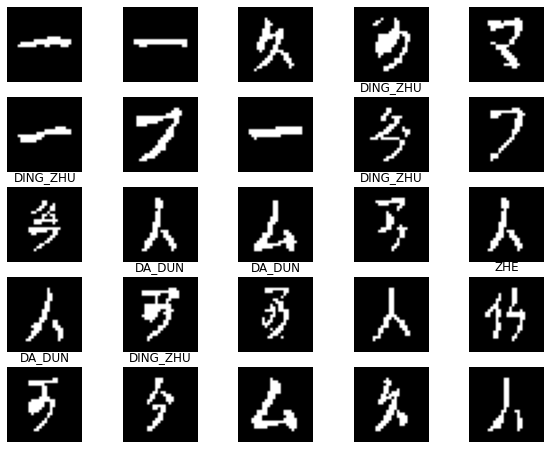

In [101]:
# visualize secondary validation data (Lu edition)
visualize_dataloader(dataloaders[ValidationEditions.NONE][LabelType.SECONDARY_BALANCED]["validation"], to_string="secondary")

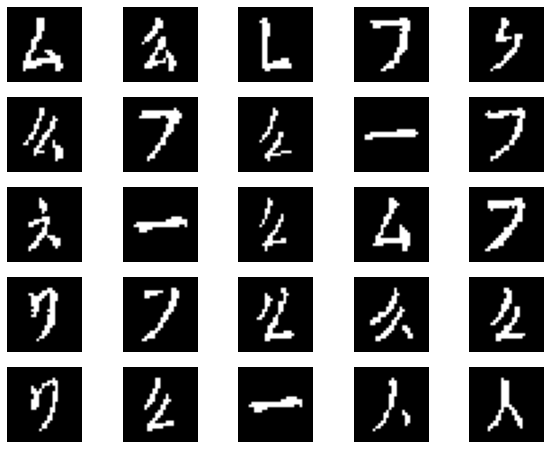

In [102]:
# visualize secondary validation data (Lu edition) - Test
visualize_dataloader(dataloaders[ValidationEditions.NONE][LabelType.SECONDARY_BALANCED]["test"], to_string="secondary")

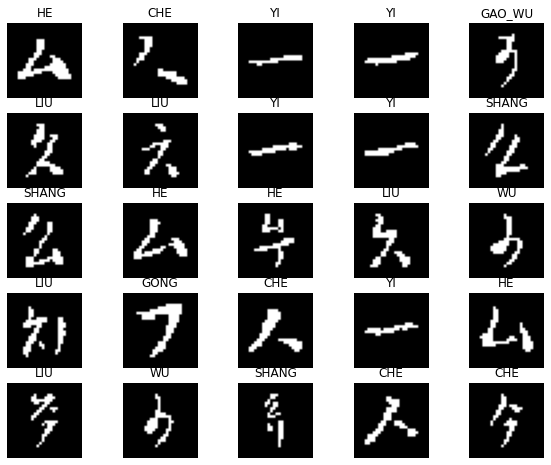

In [377]:
# visualize test data (Shanghai manuscript)
visualize_dataloader(test_dataloaders[LabelType.PITCH_BALANCED], to_string="pitch")

# Define Model (Source: https://www.kaggle.com/code/pankajj/fashion-mnist-with-pytorch-93-accuracy/notebook?scriptVersionId=14591153)

In [129]:
import torch.nn as nn

class FashionCNN(nn.Module):
    def __init__(self, num_output_classes=11):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=num_output_classes)
        self.logits = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.logits(out)
        
        return out

print("\n", FashionCNN())


 FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=11, bias=True)
  (logits): LogSoftmax(dim=1)
)


# Define Training and Validation Functions

In [404]:
from torch import optim
from torch.autograd import Variable

def loss_function(x, y):
    return nn.NLLLoss()(x, y)

def train(num_epochs, model, loaders, LABEL_TYPE, do_validate=False):
    best_model = None
    max_validate = 0
    best_epoch = 0
    
    optimizer = optim.Adam(model.parameters(), lr = 0.001)
    model.to(device)
    model.train()
        
    # Train the model
    total_step = len(loaders['train'])
    
    print(f"Training with", LABEL_TYPE)
        
    for epoch in range(num_epochs):
        for i, (images, labels, is_simple) in enumerate(loaders['train']):
            images, is_simple = images.to(device), is_simple.to(device)
            labels = labels.to(device)
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)
            
            output = model(b_x)
            
            loss = loss_function(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()
            #backpropagation, compute gradients 
            loss.backward()                # apply gradients             
            optimizer.step()      
            
            pred_y = torch.argmax(output, dim=1)              
            total_accuracy = (pred_y == labels).sum() / float(len(pred_y))
            pred_y_composite = torch.Tensor([pred_y[idx] for idx in range(len(pred_y)) if not is_simple[idx]])
            labels_composite = torch.Tensor([labels[idx] for idx in range(len(pred_y)) if not is_simple[idx]])
            composite_accuracy = (pred_y_composite == labels_composite).sum() / len(pred_y_composite) 
            pred_y_simple = torch.Tensor([pred_y[idx] for idx in range(len(pred_y)) if is_simple[idx]])
            labels_simple = torch.Tensor([labels[idx] for idx in range(len(pred_y)) if is_simple[idx]])
            simple_accuracy = (pred_y_simple == labels_simple).sum() / len(pred_y_simple)
                        
            if (i+1) % 100 == 0:
                print ('    Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Acc.(Total): {:.2f}%, Acc.(Simple): {:.2f}%, Acc.(Composite): {:.2f}%'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item(), total_accuracy*100, simple_accuracy*100, composite_accuracy*100))
        
        if do_validate:
            current_validate = validate(model, loaders, LABEL_TYPE)
            if current_validate > max_validate:
                print("***BEST MODEL***")
                best_model = copy.deepcopy(model)
                best_epoch = epoch
                max_validate = current_validate
        else:
            best_model = model
            best_epoch = epoch
            max_validate = current_validate
                
    return best_model, best_epoch, max_validate

def validate(model, loaders, LABEL_TYPE):  
    model.to(device)
    model.eval()
        
    # Train the model
    total_step = len(loaders['validation'])
    
    print(f"Validating with")
    print(LABEL_TYPE)
    
    pred_y = []
    full_labels = []
    is_simple_full = []
        
    for i, (images, labels, is_simple) in enumerate(loaders['validation']):
        images, is_simple = images.to(device), is_simple.to(device)
        labels = labels.to(device)

        # gives batch data, normalize x when iterate train_loader
        b_x = Variable(images)   # batch x
        b_y = Variable(labels)

        output = model(b_x)

        loss = loss_function(output, b_y)
        pred_y += torch.argmax(output, dim=1)
        is_simple_full += is_simple
        full_labels += labels
    
    labels = torch.Tensor(full_labels)
    pred_y = torch.Tensor(pred_y)
    is_simple = torch.Tensor(is_simple_full)
    
    total_accuracy = (pred_y == labels).sum() / float(len(pred_y))
    pred_y_simple = torch.Tensor([pred_y[idx] for idx in range(len(pred_y)) if is_simple[idx]])
    labels_simple = torch.Tensor([labels[idx] for idx in range(len(pred_y)) if is_simple[idx]])
    simple_accuracy = (pred_y_simple == labels_simple).sum() / len(pred_y_simple)   

    pred_y_composite = torch.Tensor([pred_y[idx] for idx in range(len(pred_y)) if not is_simple[idx]])
    labels_composite = torch.Tensor([labels[idx] for idx in range(len(pred_y)) if not is_simple[idx]])
    composite_accuracy = (pred_y_composite == labels_composite).sum() / len(pred_y_composite) 

    print ('    Acc.(Total): {:.2f}%, Acc.(Simple): {:.2f}%, Acc.(Composite): {:.2f}%'.format(total_accuracy*100, simple_accuracy*100, composite_accuracy*100))
    
    return total_accuracy

def test(model, test_loader, LABEL_TYPE):  
    model.to(device)
    model.eval()
        
    # Train the model
    total_step = len(test_loader)
    
    print(f"Testing with")
    print(LABEL_TYPE)
    
    pred_y = []
    full_labels = []
    is_simple_full = []
        
    for i, (images, labels, is_simple) in enumerate(test_loader):
        images, is_simple = images.to(device), is_simple.to(device)
        labels = labels.to(device)

        # gives batch data, normalize x when iterate train_loader
        b_x = Variable(images)   # batch x
        b_y = Variable(labels)

        output = model(b_x)

        loss = loss_function(output, b_y)
        pred_y += torch.argmax(output, dim=1)
        is_simple_full += is_simple
        full_labels += labels
    
    labels = torch.Tensor(full_labels)
    pred_y = torch.Tensor(pred_y)
    is_simple = torch.Tensor(is_simple_full)
    
    total_accuracy = (pred_y == labels).sum() / float(len(pred_y))
    pred_y_simple = torch.Tensor([pred_y[idx] for idx in range(len(pred_y)) if is_simple[idx]])
    labels_simple = torch.Tensor([labels[idx] for idx in range(len(pred_y)) if is_simple[idx]])
    simple_accuracy = (pred_y_simple == labels_simple).sum() / len(pred_y_simple)   

    pred_y_composite = torch.Tensor([pred_y[idx] for idx in range(len(pred_y)) if not is_simple[idx]])
    labels_composite = torch.Tensor([labels[idx] for idx in range(len(pred_y)) if not is_simple[idx]])
    composite_accuracy = (pred_y_composite == labels_composite).sum() / len(pred_y_composite) 

    print ('    Acc.(Total): {:.2f}%, Acc.(Simple): {:.2f}%, Acc.(Composite): {:.2f}%'.format(total_accuracy*100, simple_accuracy*100, composite_accuracy*100))
    
    return total_accuracy, pred_y, labels


def train_and_save_all_models(number_of_trials=10, num_epochs=10):
    model_dict = {}
    for val_edition in dataclasses.astuple(ValidationEditions()):
        model_dict[val_edition] = {}
        for label_type in dataclasses.astuple(LabelType()):
            
            if label_type.split("_")[0] == "pitch":
                num_output_classes = 11
            else:
                num_output_classes = 7
            
            epoch_acc_list = []
            for idx in range(number_of_trials):
                model, epoch, accuracy = train(num_epochs, FashionCNN(num_output_classes), dataloaders[val_edition][label_type], label_type, do_validate=True)
                torch.save(model.state_dict(), f"./{val_edition}-{label_type}-{idx}.std")
                epoch_acc_list.append({"epoch": epoch, "val_accuracy": accuracy})
                
            model_dict[val_edition][label_type] = epoch_acc_list
    return model_dict

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("DEVICE CODE IS EXECUTED ON:", device)

DEVICE CODE IS EXECUTED ON: cpu


# Train for each of the five validation settings (20% of whole data, Lu edition, ...) for each pitch and secondary symbols, and 5 times each with maximum 15 epochs. Take the epoch with the highest accuracy on the validation set.

In [106]:
model_dict = train_and_save_all_models(5, 15)

import pickle
with open('model_stats.pkl', 'wb') as handle:
    pickle.dump(model_dict, handle)

Training with pitch_balanced


/home/tristan/.local/lib/python3.10/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


    Epoch [1/15], Step [100/600], Loss: 0.5096, Acc.(Total): 81.00%, Acc.(Simple): 90.14%, Acc.(Composite): 58.62%
    Epoch [1/15], Step [200/600], Loss: 0.5775, Acc.(Total): 79.00%, Acc.(Simple): 88.00%, Acc.(Composite): 52.00%
    Epoch [1/15], Step [300/600], Loss: 0.3169, Acc.(Total): 86.00%, Acc.(Simple): 95.95%, Acc.(Composite): 57.69%
    Epoch [1/15], Step [400/600], Loss: 0.2805, Acc.(Total): 92.00%, Acc.(Simple): 96.25%, Acc.(Composite): 75.00%
    Epoch [1/15], Step [500/600], Loss: 0.3443, Acc.(Total): 88.00%, Acc.(Simple): 93.33%, Acc.(Composite): 72.00%
    Epoch [1/15], Step [600/600], Loss: 0.3263, Acc.(Total): 91.00%, Acc.(Simple): 98.61%, Acc.(Composite): 71.43%
Validating with
pitch_balanced
    Acc.(Total): 86.38%, Acc.(Simple): 93.54%, Acc.(Composite): 65.53%
***BEST MODEL***
    Epoch [2/15], Step [100/600], Loss: 0.2272, Acc.(Total): 92.00%, Acc.(Simple): 97.37%, Acc.(Composite): 75.00%
    Epoch [2/15], Step [200/600], Loss: 0.1271, Acc.(Total): 96.00%, Acc.(Si

    Epoch [11/15], Step [300/600], Loss: 0.2088, Acc.(Total): 93.00%, Acc.(Simple): 94.87%, Acc.(Composite): 86.36%
    Epoch [11/15], Step [400/600], Loss: 0.0718, Acc.(Total): 98.00%, Acc.(Simple): 100.00%, Acc.(Composite): 87.50%
    Epoch [11/15], Step [500/600], Loss: 0.0358, Acc.(Total): 99.00%, Acc.(Simple): 100.00%, Acc.(Composite): 96.55%
    Epoch [11/15], Step [600/600], Loss: 0.0650, Acc.(Total): 97.00%, Acc.(Simple): 98.63%, Acc.(Composite): 92.59%
Validating with
pitch_balanced
    Acc.(Total): 89.69%, Acc.(Simple): 94.05%, Acc.(Composite): 76.74%
    Epoch [12/15], Step [100/600], Loss: 0.2086, Acc.(Total): 94.00%, Acc.(Simple): 97.33%, Acc.(Composite): 84.00%
    Epoch [12/15], Step [200/600], Loss: 0.1101, Acc.(Total): 97.00%, Acc.(Simple): 97.33%, Acc.(Composite): 96.00%
    Epoch [12/15], Step [300/600], Loss: 0.1893, Acc.(Total): 93.00%, Acc.(Simple): 93.44%, Acc.(Composite): 92.31%
    Epoch [12/15], Step [400/600], Loss: 0.0468, Acc.(Total): 99.00%, Acc.(Simple): 

    Epoch [6/15], Step [500/600], Loss: 0.1052, Acc.(Total): 97.00%, Acc.(Simple): 98.67%, Acc.(Composite): 92.00%
    Epoch [6/15], Step [600/600], Loss: 0.1683, Acc.(Total): 94.00%, Acc.(Simple): 94.59%, Acc.(Composite): 92.31%
Validating with
pitch_balanced
    Acc.(Total): 90.31%, Acc.(Simple): 94.48%, Acc.(Composite): 75.97%
    Epoch [7/15], Step [100/600], Loss: 0.0913, Acc.(Total): 97.00%, Acc.(Simple): 98.75%, Acc.(Composite): 90.00%
    Epoch [7/15], Step [200/600], Loss: 0.1487, Acc.(Total): 96.00%, Acc.(Simple): 98.75%, Acc.(Composite): 85.00%
    Epoch [7/15], Step [300/600], Loss: 0.0709, Acc.(Total): 99.00%, Acc.(Simple): 100.00%, Acc.(Composite): 93.33%
    Epoch [7/15], Step [400/600], Loss: 0.1591, Acc.(Total): 95.00%, Acc.(Simple): 98.55%, Acc.(Composite): 87.10%
    Epoch [7/15], Step [500/600], Loss: 0.1490, Acc.(Total): 95.00%, Acc.(Simple): 96.15%, Acc.(Composite): 90.91%
    Epoch [7/15], Step [600/600], Loss: 0.1832, Acc.(Total): 94.00%, Acc.(Simple): 98.70%, A

    Acc.(Total): 86.99%, Acc.(Simple): 94.07%, Acc.(Composite): 63.81%
***BEST MODEL***
    Epoch [2/15], Step [100/600], Loss: 0.3847, Acc.(Total): 86.00%, Acc.(Simple): 94.59%, Acc.(Composite): 61.54%
    Epoch [2/15], Step [200/600], Loss: 0.2743, Acc.(Total): 90.00%, Acc.(Simple): 94.87%, Acc.(Composite): 72.73%
    Epoch [2/15], Step [300/600], Loss: 0.2568, Acc.(Total): 92.00%, Acc.(Simple): 97.26%, Acc.(Composite): 77.78%
    Epoch [2/15], Step [400/600], Loss: 0.1545, Acc.(Total): 92.00%, Acc.(Simple): 96.10%, Acc.(Composite): 78.26%
    Epoch [2/15], Step [500/600], Loss: 0.3142, Acc.(Total): 91.00%, Acc.(Simple): 95.83%, Acc.(Composite): 78.57%
    Epoch [2/15], Step [600/600], Loss: 0.4839, Acc.(Total): 88.00%, Acc.(Simple): 92.96%, Acc.(Composite): 75.86%
Validating with
pitch_balanced
    Acc.(Total): 91.70%, Acc.(Simple): 97.95%, Acc.(Composite): 71.05%
***BEST MODEL***
    Epoch [3/15], Step [100/600], Loss: 0.2096, Acc.(Total): 93.00%, Acc.(Simple): 96.34%, Acc.(Composi

    Epoch [12/15], Step [300/600], Loss: 0.1866, Acc.(Total): 95.00%, Acc.(Simple): 97.26%, Acc.(Composite): 88.89%
    Epoch [12/15], Step [400/600], Loss: 0.0831, Acc.(Total): 96.00%, Acc.(Simple): 98.59%, Acc.(Composite): 89.66%
    Epoch [12/15], Step [500/600], Loss: 0.1300, Acc.(Total): 94.00%, Acc.(Simple): 97.01%, Acc.(Composite): 87.88%
    Epoch [12/15], Step [600/600], Loss: 0.0837, Acc.(Total): 98.00%, Acc.(Simple): 100.00%, Acc.(Composite): 94.29%
Validating with
pitch_balanced
    Acc.(Total): 90.48%, Acc.(Simple): 95.15%, Acc.(Composite): 74.42%
    Epoch [13/15], Step [100/600], Loss: 0.0748, Acc.(Total): 97.00%, Acc.(Simple): 100.00%, Acc.(Composite): 87.50%
    Epoch [13/15], Step [200/600], Loss: 0.0551, Acc.(Total): 98.00%, Acc.(Simple): 98.78%, Acc.(Composite): 94.44%
    Epoch [13/15], Step [300/600], Loss: 0.1533, Acc.(Total): 94.00%, Acc.(Simple): 100.00%, Acc.(Composite): 77.78%
    Epoch [13/15], Step [400/600], Loss: 0.1931, Acc.(Total): 97.00%, Acc.(Simple):

    Epoch [7/15], Step [500/600], Loss: 0.0693, Acc.(Total): 98.00%, Acc.(Simple): 100.00%, Acc.(Composite): 92.00%
    Epoch [7/15], Step [600/600], Loss: 0.1469, Acc.(Total): 97.00%, Acc.(Simple): 100.00%, Acc.(Composite): 88.00%
Validating with
pitch_balanced
    Acc.(Total): 90.83%, Acc.(Simple): 97.23%, Acc.(Composite): 70.97%
    Epoch [8/15], Step [100/600], Loss: 0.1771, Acc.(Total): 94.00%, Acc.(Simple): 96.05%, Acc.(Composite): 87.50%
    Epoch [8/15], Step [200/600], Loss: 0.1262, Acc.(Total): 97.00%, Acc.(Simple): 98.67%, Acc.(Composite): 92.00%
    Epoch [8/15], Step [300/600], Loss: 0.1035, Acc.(Total): 95.00%, Acc.(Simple): 97.18%, Acc.(Composite): 89.66%
    Epoch [8/15], Step [400/600], Loss: 0.1390, Acc.(Total): 96.00%, Acc.(Simple): 97.26%, Acc.(Composite): 92.59%
    Epoch [8/15], Step [500/600], Loss: 0.1038, Acc.(Total): 95.00%, Acc.(Simple): 93.83%, Acc.(Composite): 100.00%
    Epoch [8/15], Step [600/600], Loss: 0.2355, Acc.(Total): 95.00%, Acc.(Simple): 98.68%,

    Acc.(Total): 92.23%, Acc.(Simple): 95.68%, Acc.(Composite): 80.83%
***BEST MODEL***
    Epoch [3/15], Step [100/600], Loss: 0.2238, Acc.(Total): 93.00%, Acc.(Simple): 96.43%, Acc.(Composite): 75.00%
    Epoch [3/15], Step [200/600], Loss: 0.1881, Acc.(Total): 94.00%, Acc.(Simple): 95.95%, Acc.(Composite): 88.46%
    Epoch [3/15], Step [300/600], Loss: 0.3992, Acc.(Total): 88.00%, Acc.(Simple): 95.65%, Acc.(Composite): 70.97%
    Epoch [3/15], Step [400/600], Loss: 0.2702, Acc.(Total): 92.00%, Acc.(Simple): 97.33%, Acc.(Composite): 76.00%
    Epoch [3/15], Step [500/600], Loss: 0.2530, Acc.(Total): 91.00%, Acc.(Simple): 95.83%, Acc.(Composite): 78.57%
    Epoch [3/15], Step [600/600], Loss: 0.1985, Acc.(Total): 94.00%, Acc.(Simple): 96.00%, Acc.(Composite): 88.00%
Validating with
pitch_balanced
    Acc.(Total): 90.39%, Acc.(Simple): 95.40%, Acc.(Composite): 74.55%
    Epoch [4/15], Step [100/600], Loss: 0.3747, Acc.(Total): 94.00%, Acc.(Simple): 97.33%, Acc.(Composite): 84.00%
    E

    Epoch [13/15], Step [200/600], Loss: 0.1569, Acc.(Total): 94.00%, Acc.(Simple): 95.59%, Acc.(Composite): 90.62%
    Epoch [13/15], Step [300/600], Loss: 0.1017, Acc.(Total): 96.00%, Acc.(Simple): 97.30%, Acc.(Composite): 92.31%
    Epoch [13/15], Step [400/600], Loss: 0.1039, Acc.(Total): 97.00%, Acc.(Simple): 97.22%, Acc.(Composite): 96.43%
    Epoch [13/15], Step [500/600], Loss: 0.0778, Acc.(Total): 97.00%, Acc.(Simple): 96.15%, Acc.(Composite): 100.00%
    Epoch [13/15], Step [600/600], Loss: 0.0692, Acc.(Total): 98.00%, Acc.(Simple): 98.70%, Acc.(Composite): 95.65%
Validating with
pitch_balanced
    Acc.(Total): 89.61%, Acc.(Simple): 95.37%, Acc.(Composite): 71.89%
    Epoch [14/15], Step [100/600], Loss: 0.0388, Acc.(Total): 99.00%, Acc.(Simple): 100.00%, Acc.(Composite): 95.45%
    Epoch [14/15], Step [200/600], Loss: 0.0955, Acc.(Total): 97.00%, Acc.(Simple): 98.59%, Acc.(Composite): 93.10%
    Epoch [14/15], Step [300/600], Loss: 0.1828, Acc.(Total): 95.00%, Acc.(Simple): 

    Epoch [8/15], Step [300/600], Loss: 0.1681, Acc.(Total): 96.00%, Acc.(Simple): 92.86%, Acc.(Composite): 96.51%
    Epoch [8/15], Step [400/600], Loss: 0.0890, Acc.(Total): 96.00%, Acc.(Simple): 90.91%, Acc.(Composite): 96.63%
    Epoch [8/15], Step [500/600], Loss: 0.1017, Acc.(Total): 98.00%, Acc.(Simple): 100.00%, Acc.(Composite): 97.75%
    Epoch [8/15], Step [600/600], Loss: 0.1212, Acc.(Total): 95.00%, Acc.(Simple): 100.00%, Acc.(Composite): 94.38%
Validating with
secondary_balanced
    Acc.(Total): 87.25%, Acc.(Simple): 97.44%, Acc.(Composite): 85.64%
    Epoch [9/15], Step [100/600], Loss: 0.0338, Acc.(Total): 99.00%, Acc.(Simple): 100.00%, Acc.(Composite): 98.77%
    Epoch [9/15], Step [200/600], Loss: 0.2307, Acc.(Total): 97.00%, Acc.(Simple): 100.00%, Acc.(Composite): 96.47%
    Epoch [9/15], Step [300/600], Loss: 0.1580, Acc.(Total): 95.00%, Acc.(Simple): 90.00%, Acc.(Composite): 95.56%
    Epoch [9/15], Step [400/600], Loss: 0.1925, Acc.(Total): 94.00%, Acc.(Simple): 10

    Epoch [3/15], Step [400/600], Loss: 0.3279, Acc.(Total): 88.00%, Acc.(Simple): 88.89%, Acc.(Composite): 87.91%
    Epoch [3/15], Step [500/600], Loss: 0.2333, Acc.(Total): 93.00%, Acc.(Simple): 94.74%, Acc.(Composite): 92.59%
    Epoch [3/15], Step [600/600], Loss: 0.4209, Acc.(Total): 90.00%, Acc.(Simple): 75.00%, Acc.(Composite): 91.30%
Validating with
secondary_balanced
    Acc.(Total): 85.76%, Acc.(Simple): 98.14%, Acc.(Composite): 83.74%
    Epoch [4/15], Step [100/600], Loss: 0.2536, Acc.(Total): 91.00%, Acc.(Simple): 100.00%, Acc.(Composite): 90.32%
    Epoch [4/15], Step [200/600], Loss: 0.2317, Acc.(Total): 94.00%, Acc.(Simple): 100.00%, Acc.(Composite): 92.31%
    Epoch [4/15], Step [300/600], Loss: 0.1332, Acc.(Total): 95.00%, Acc.(Simple): 100.00%, Acc.(Composite): 94.25%
    Epoch [4/15], Step [400/600], Loss: 0.2166, Acc.(Total): 94.00%, Acc.(Simple): 100.00%, Acc.(Composite): 92.94%
    Epoch [4/15], Step [500/600], Loss: 0.1934, Acc.(Total): 96.00%, Acc.(Simple): 86

    Epoch [13/15], Step [500/600], Loss: 0.1537, Acc.(Total): 96.00%, Acc.(Simple): 100.00%, Acc.(Composite): 95.35%
    Epoch [13/15], Step [600/600], Loss: 0.1381, Acc.(Total): 95.00%, Acc.(Simple): 100.00%, Acc.(Composite): 94.12%
Validating with
secondary_balanced
    Acc.(Total): 91.09%, Acc.(Simple): 99.40%, Acc.(Composite): 89.66%
***BEST MODEL***
    Epoch [14/15], Step [100/600], Loss: 0.0623, Acc.(Total): 99.00%, Acc.(Simple): 100.00%, Acc.(Composite): 98.81%
    Epoch [14/15], Step [200/600], Loss: 0.1435, Acc.(Total): 95.00%, Acc.(Simple): 95.00%, Acc.(Composite): 95.00%
    Epoch [14/15], Step [300/600], Loss: 0.1706, Acc.(Total): 96.00%, Acc.(Simple): 93.75%, Acc.(Composite): 96.43%
    Epoch [14/15], Step [400/600], Loss: 0.1215, Acc.(Total): 96.00%, Acc.(Simple): 93.75%, Acc.(Composite): 96.43%
    Epoch [14/15], Step [500/600], Loss: 0.1756, Acc.(Total): 96.00%, Acc.(Simple): 100.00%, Acc.(Composite): 95.12%
    Epoch [14/15], Step [600/600], Loss: 0.0885, Acc.(Total):

    Epoch [8/15], Step [600/600], Loss: 0.0688, Acc.(Total): 98.00%, Acc.(Simple): 100.00%, Acc.(Composite): 97.67%
Validating with
secondary_balanced
    Acc.(Total): 88.47%, Acc.(Simple): 99.45%, Acc.(Composite): 86.41%
***BEST MODEL***
    Epoch [9/15], Step [100/600], Loss: 0.1359, Acc.(Total): 96.00%, Acc.(Simple): 91.67%, Acc.(Composite): 96.59%
    Epoch [9/15], Step [200/600], Loss: 0.1114, Acc.(Total): 96.00%, Acc.(Simple): 86.67%, Acc.(Composite): 97.65%
    Epoch [9/15], Step [300/600], Loss: 0.1163, Acc.(Total): 94.00%, Acc.(Simple): 100.00%, Acc.(Composite): 93.10%
    Epoch [9/15], Step [400/600], Loss: 0.1683, Acc.(Total): 94.00%, Acc.(Simple): 93.33%, Acc.(Composite): 94.12%
    Epoch [9/15], Step [500/600], Loss: 0.1571, Acc.(Total): 96.00%, Acc.(Simple): 100.00%, Acc.(Composite): 95.40%
    Epoch [9/15], Step [600/600], Loss: 0.0687, Acc.(Total): 97.00%, Acc.(Simple): 100.00%, Acc.(Composite): 96.63%
Validating with
secondary_balanced
    Acc.(Total): 90.66%, Acc.(Sim

    Acc.(Total): 90.66%, Acc.(Simple): 95.97%, Acc.(Composite): 89.86%
***BEST MODEL***
    Epoch [4/15], Step [100/600], Loss: 0.2565, Acc.(Total): 92.00%, Acc.(Simple): 95.00%, Acc.(Composite): 91.25%
    Epoch [4/15], Step [200/600], Loss: 0.2056, Acc.(Total): 94.00%, Acc.(Simple): 100.00%, Acc.(Composite): 93.02%
    Epoch [4/15], Step [300/600], Loss: 0.1050, Acc.(Total): 98.00%, Acc.(Simple): 100.00%, Acc.(Composite): 97.65%
    Epoch [4/15], Step [400/600], Loss: 0.1298, Acc.(Total): 94.00%, Acc.(Simple): 88.89%, Acc.(Composite): 95.12%
    Epoch [4/15], Step [500/600], Loss: 0.2928, Acc.(Total): 92.00%, Acc.(Simple): 100.00%, Acc.(Composite): 90.36%
    Epoch [4/15], Step [600/600], Loss: 0.3420, Acc.(Total): 92.00%, Acc.(Simple): 83.33%, Acc.(Composite): 93.90%
Validating with
secondary_balanced
    Acc.(Total): 85.59%, Acc.(Simple): 97.60%, Acc.(Composite): 83.54%
    Epoch [5/15], Step [100/600], Loss: 0.1729, Acc.(Total): 94.00%, Acc.(Simple): 100.00%, Acc.(Composite): 92.5

    Epoch [14/15], Step [200/600], Loss: 0.1013, Acc.(Total): 97.00%, Acc.(Simple): 94.12%, Acc.(Composite): 97.59%
    Epoch [14/15], Step [300/600], Loss: 0.1875, Acc.(Total): 95.00%, Acc.(Simple): 100.00%, Acc.(Composite): 94.38%
    Epoch [14/15], Step [400/600], Loss: 0.0618, Acc.(Total): 99.00%, Acc.(Simple): 100.00%, Acc.(Composite): 98.85%
    Epoch [14/15], Step [500/600], Loss: 0.2373, Acc.(Total): 95.00%, Acc.(Simple): 100.00%, Acc.(Composite): 94.44%
    Epoch [14/15], Step [600/600], Loss: 0.0864, Acc.(Total): 96.00%, Acc.(Simple): 92.31%, Acc.(Composite): 96.55%
Validating with
secondary_balanced
    Acc.(Total): 86.64%, Acc.(Simple): 100.00%, Acc.(Composite): 84.45%
    Epoch [15/15], Step [100/600], Loss: 0.0985, Acc.(Total): 96.00%, Acc.(Simple): 94.12%, Acc.(Composite): 96.39%
    Epoch [15/15], Step [200/600], Loss: 0.1005, Acc.(Total): 96.00%, Acc.(Simple): 100.00%, Acc.(Composite): 95.00%
    Epoch [15/15], Step [300/600], Loss: 0.1308, Acc.(Total): 95.00%, Acc.(Si

    Epoch [9/15], Step [300/600], Loss: 0.2177, Acc.(Total): 93.00%, Acc.(Simple): 88.24%, Acc.(Composite): 93.98%
    Epoch [9/15], Step [400/600], Loss: 0.0474, Acc.(Total): 99.00%, Acc.(Simple): 100.00%, Acc.(Composite): 98.85%
    Epoch [9/15], Step [500/600], Loss: 0.1563, Acc.(Total): 96.00%, Acc.(Simple): 66.67%, Acc.(Composite): 98.90%
    Epoch [9/15], Step [600/600], Loss: 0.1027, Acc.(Total): 94.00%, Acc.(Simple): 88.24%, Acc.(Composite): 95.18%
Validating with
secondary_balanced
    Acc.(Total): 90.22%, Acc.(Simple): 96.30%, Acc.(Composite): 89.22%
    Epoch [10/15], Step [100/600], Loss: 0.1212, Acc.(Total): 95.00%, Acc.(Simple): 100.00%, Acc.(Composite): 94.25%
    Epoch [10/15], Step [200/600], Loss: 0.0917, Acc.(Total): 96.00%, Acc.(Simple): 100.00%, Acc.(Composite): 95.70%
    Epoch [10/15], Step [300/600], Loss: 0.1644, Acc.(Total): 94.00%, Acc.(Simple): 100.00%, Acc.(Composite): 93.41%
    Epoch [10/15], Step [400/600], Loss: 0.1202, Acc.(Total): 96.00%, Acc.(Simple)

    Epoch [4/15], Step [500/600], Loss: 0.0987, Acc.(Total): 99.00%, Acc.(Simple): 98.70%, Acc.(Composite): 100.00%
    Epoch [4/15], Step [600/600], Loss: 0.1514, Acc.(Total): 96.00%, Acc.(Simple): 98.72%, Acc.(Composite): 86.36%
Validating with
pitch_balanced
    Acc.(Total): 93.44%, Acc.(Simple): 97.14%, Acc.(Composite): 81.84%
    Epoch [5/15], Step [100/600], Loss: 0.1346, Acc.(Total): 96.00%, Acc.(Simple): 98.75%, Acc.(Composite): 85.00%
    Epoch [5/15], Step [200/600], Loss: 0.1715, Acc.(Total): 92.00%, Acc.(Simple): 93.42%, Acc.(Composite): 87.50%
    Epoch [5/15], Step [300/600], Loss: 0.2027, Acc.(Total): 94.00%, Acc.(Simple): 100.00%, Acc.(Composite): 83.33%
    Epoch [5/15], Step [400/600], Loss: 0.0871, Acc.(Total): 94.00%, Acc.(Simple): 96.00%, Acc.(Composite): 88.00%
    Epoch [5/15], Step [500/600], Loss: 0.2619, Acc.(Total): 93.00%, Acc.(Simple): 100.00%, Acc.(Composite): 74.07%
    Epoch [5/15], Step [600/600], Loss: 0.2134, Acc.(Total): 94.00%, Acc.(Simple): 96.00%,

    Acc.(Total): 93.44%, Acc.(Simple): 96.48%, Acc.(Composite): 84.14%
    Epoch [15/15], Step [100/600], Loss: 0.0947, Acc.(Total): 97.00%, Acc.(Simple): 98.67%, Acc.(Composite): 92.00%
    Epoch [15/15], Step [200/600], Loss: 0.0788, Acc.(Total): 98.00%, Acc.(Simple): 98.73%, Acc.(Composite): 95.24%
    Epoch [15/15], Step [300/600], Loss: 0.1143, Acc.(Total): 96.00%, Acc.(Simple): 100.00%, Acc.(Composite): 82.61%
    Epoch [15/15], Step [400/600], Loss: 0.0976, Acc.(Total): 97.00%, Acc.(Simple): 98.68%, Acc.(Composite): 91.67%
    Epoch [15/15], Step [500/600], Loss: 0.1669, Acc.(Total): 95.00%, Acc.(Simple): 94.44%, Acc.(Composite): 96.43%
    Epoch [15/15], Step [600/600], Loss: 0.0530, Acc.(Total): 98.00%, Acc.(Simple): 100.00%, Acc.(Composite): 94.12%
Validating with
pitch_balanced
    Acc.(Total): 93.16%, Acc.(Simple): 97.41%, Acc.(Composite): 80.17%
Training with pitch_balanced
    Epoch [1/15], Step [100/600], Loss: 0.8075, Acc.(Total): 77.00%, Acc.(Simple): 85.14%, Acc.(Comp

    Epoch [10/15], Step [300/600], Loss: 0.1792, Acc.(Total): 94.00%, Acc.(Simple): 94.94%, Acc.(Composite): 90.48%
    Epoch [10/15], Step [400/600], Loss: 0.1550, Acc.(Total): 95.00%, Acc.(Simple): 98.77%, Acc.(Composite): 78.95%
    Epoch [10/15], Step [500/600], Loss: 0.1132, Acc.(Total): 95.00%, Acc.(Simple): 95.71%, Acc.(Composite): 93.33%
    Epoch [10/15], Step [600/600], Loss: 0.2744, Acc.(Total): 90.00%, Acc.(Simple): 98.63%, Acc.(Composite): 66.67%
Validating with
pitch_balanced
    Acc.(Total): 92.81%, Acc.(Simple): 96.57%, Acc.(Composite): 81.25%
    Epoch [11/15], Step [100/600], Loss: 0.0968, Acc.(Total): 97.00%, Acc.(Simple): 98.73%, Acc.(Composite): 90.48%
    Epoch [11/15], Step [200/600], Loss: 0.1623, Acc.(Total): 95.00%, Acc.(Simple): 98.70%, Acc.(Composite): 82.61%
    Epoch [11/15], Step [300/600], Loss: 0.3630, Acc.(Total): 91.00%, Acc.(Simple): 98.55%, Acc.(Composite): 74.19%
    Epoch [11/15], Step [400/600], Loss: 0.1145, Acc.(Total): 97.00%, Acc.(Simple): 98

    Epoch [5/15], Step [500/600], Loss: 0.2190, Acc.(Total): 92.00%, Acc.(Simple): 98.67%, Acc.(Composite): 72.00%
    Epoch [5/15], Step [600/600], Loss: 0.2667, Acc.(Total): 94.00%, Acc.(Simple): 97.26%, Acc.(Composite): 85.19%
Validating with
pitch_balanced
    Acc.(Total): 93.85%, Acc.(Simple): 97.48%, Acc.(Composite): 84.46%
    Epoch [6/15], Step [100/600], Loss: 0.2797, Acc.(Total): 89.00%, Acc.(Simple): 94.52%, Acc.(Composite): 74.07%
    Epoch [6/15], Step [200/600], Loss: 0.0630, Acc.(Total): 99.00%, Acc.(Simple): 100.00%, Acc.(Composite): 96.30%
    Epoch [6/15], Step [300/600], Loss: 0.0843, Acc.(Total): 99.00%, Acc.(Simple): 100.00%, Acc.(Composite): 96.97%
    Epoch [6/15], Step [400/600], Loss: 0.0483, Acc.(Total): 99.00%, Acc.(Simple): 100.00%, Acc.(Composite): 96.00%
    Epoch [6/15], Step [500/600], Loss: 0.1253, Acc.(Total): 94.00%, Acc.(Simple): 96.15%, Acc.(Composite): 86.36%
    Epoch [6/15], Step [600/600], Loss: 0.1627, Acc.(Total): 97.00%, Acc.(Simple): 100.00%

    Acc.(Total): 93.16%, Acc.(Simple): 97.13%, Acc.(Composite): 81.02%
Training with pitch_balanced
    Epoch [1/15], Step [100/600], Loss: 0.6077, Acc.(Total): 82.00%, Acc.(Simple): 94.37%, Acc.(Composite): 51.72%
    Epoch [1/15], Step [200/600], Loss: 0.4139, Acc.(Total): 89.00%, Acc.(Simple): 95.00%, Acc.(Composite): 65.00%
    Epoch [1/15], Step [300/600], Loss: 0.5604, Acc.(Total): 83.00%, Acc.(Simple): 95.59%, Acc.(Composite): 56.25%
    Epoch [1/15], Step [400/600], Loss: 0.2313, Acc.(Total): 90.00%, Acc.(Simple): 94.81%, Acc.(Composite): 73.91%
    Epoch [1/15], Step [500/600], Loss: 0.2291, Acc.(Total): 90.00%, Acc.(Simple): 96.15%, Acc.(Composite): 68.18%
    Epoch [1/15], Step [600/600], Loss: 0.3328, Acc.(Total): 90.00%, Acc.(Simple): 94.81%, Acc.(Composite): 73.91%
Validating with
pitch_balanced
    Acc.(Total): 91.69%, Acc.(Simple): 98.36%, Acc.(Composite): 69.67%
***BEST MODEL***
    Epoch [2/15], Step [100/600], Loss: 0.3143, Acc.(Total): 91.00%, Acc.(Simple): 96.00%, 

    Epoch [11/15], Step [300/600], Loss: 0.0819, Acc.(Total): 97.00%, Acc.(Simple): 98.70%, Acc.(Composite): 91.30%
    Epoch [11/15], Step [400/600], Loss: 0.1199, Acc.(Total): 97.00%, Acc.(Simple): 97.10%, Acc.(Composite): 96.77%
    Epoch [11/15], Step [500/600], Loss: 0.1984, Acc.(Total): 96.00%, Acc.(Simple): 96.15%, Acc.(Composite): 95.45%
    Epoch [11/15], Step [600/600], Loss: 0.1384, Acc.(Total): 94.00%, Acc.(Simple): 95.83%, Acc.(Composite): 89.29%
Validating with
pitch_balanced
    Acc.(Total): 93.85%, Acc.(Simple): 98.76%, Acc.(Composite): 80.57%
    Epoch [12/15], Step [100/600], Loss: 0.1102, Acc.(Total): 98.00%, Acc.(Simple): 100.00%, Acc.(Composite): 91.30%
    Epoch [12/15], Step [200/600], Loss: 0.0976, Acc.(Total): 96.00%, Acc.(Simple): 96.15%, Acc.(Composite): 95.45%
    Epoch [12/15], Step [300/600], Loss: 0.0949, Acc.(Total): 98.00%, Acc.(Simple): 100.00%, Acc.(Composite): 92.31%
    Epoch [12/15], Step [400/600], Loss: 0.0327, Acc.(Total): 99.00%, Acc.(Simple): 

    Epoch [6/15], Step [500/600], Loss: 0.1394, Acc.(Total): 94.00%, Acc.(Simple): 92.96%, Acc.(Composite): 96.55%
    Epoch [6/15], Step [600/600], Loss: 0.0550, Acc.(Total): 99.00%, Acc.(Simple): 98.77%, Acc.(Composite): 100.00%
Validating with
pitch_balanced
    Acc.(Total): 92.88%, Acc.(Simple): 97.70%, Acc.(Composite): 79.90%
    Epoch [7/15], Step [100/600], Loss: 0.2133, Acc.(Total): 91.00%, Acc.(Simple): 93.67%, Acc.(Composite): 80.95%
    Epoch [7/15], Step [200/600], Loss: 0.1491, Acc.(Total): 94.00%, Acc.(Simple): 97.37%, Acc.(Composite): 83.33%
    Epoch [7/15], Step [300/600], Loss: 0.1347, Acc.(Total): 96.00%, Acc.(Simple): 98.57%, Acc.(Composite): 90.00%
    Epoch [7/15], Step [400/600], Loss: 0.1064, Acc.(Total): 96.00%, Acc.(Simple): 95.89%, Acc.(Composite): 96.30%
    Epoch [7/15], Step [500/600], Loss: 0.1915, Acc.(Total): 92.00%, Acc.(Simple): 93.75%, Acc.(Composite): 85.00%
    Epoch [7/15], Step [600/600], Loss: 0.0988, Acc.(Total): 95.00%, Acc.(Simple): 96.15%, A

    Acc.(Total): 87.22%, Acc.(Simple): 90.05%, Acc.(Composite): 86.76%
***BEST MODEL***
    Epoch [2/15], Step [100/600], Loss: 0.1947, Acc.(Total): 93.00%, Acc.(Simple): 94.44%, Acc.(Composite): 92.68%
    Epoch [2/15], Step [200/600], Loss: 0.2893, Acc.(Total): 89.00%, Acc.(Simple): 81.25%, Acc.(Composite): 90.48%
    Epoch [2/15], Step [300/600], Loss: 0.2210, Acc.(Total): 93.00%, Acc.(Simple): 100.00%, Acc.(Composite): 91.95%
    Epoch [2/15], Step [400/600], Loss: 0.3394, Acc.(Total): 91.00%, Acc.(Simple): 92.31%, Acc.(Composite): 90.80%
    Epoch [2/15], Step [500/600], Loss: 0.3154, Acc.(Total): 86.00%, Acc.(Simple): 88.24%, Acc.(Composite): 85.54%
    Epoch [2/15], Step [600/600], Loss: 0.2228, Acc.(Total): 89.00%, Acc.(Simple): 100.00%, Acc.(Composite): 88.04%
Validating with
secondary_balanced
    Acc.(Total): 88.06%, Acc.(Simple): 95.85%, Acc.(Composite): 86.84%
***BEST MODEL***
    Epoch [3/15], Step [100/600], Loss: 0.2507, Acc.(Total): 90.00%, Acc.(Simple): 87.50%, Acc.(C

    Epoch [12/15], Step [200/600], Loss: 0.1662, Acc.(Total): 96.00%, Acc.(Simple): 100.00%, Acc.(Composite): 95.18%
    Epoch [12/15], Step [300/600], Loss: 0.1289, Acc.(Total): 96.00%, Acc.(Simple): 100.00%, Acc.(Composite): 95.40%
    Epoch [12/15], Step [400/600], Loss: 0.0675, Acc.(Total): 98.00%, Acc.(Simple): 100.00%, Acc.(Composite): 97.65%
    Epoch [12/15], Step [500/600], Loss: 0.0861, Acc.(Total): 97.00%, Acc.(Simple): 91.67%, Acc.(Composite): 97.73%
    Epoch [12/15], Step [600/600], Loss: 0.0402, Acc.(Total): 98.00%, Acc.(Simple): 93.75%, Acc.(Composite): 98.81%
Validating with
secondary_balanced
    Acc.(Total): 87.57%, Acc.(Simple): 88.10%, Acc.(Composite): 87.50%
    Epoch [13/15], Step [100/600], Loss: 0.1370, Acc.(Total): 96.00%, Acc.(Simple): 88.89%, Acc.(Composite): 96.70%
    Epoch [13/15], Step [200/600], Loss: 0.1585, Acc.(Total): 94.00%, Acc.(Simple): 94.74%, Acc.(Composite): 93.83%
    Epoch [13/15], Step [300/600], Loss: 0.1731, Acc.(Total): 95.00%, Acc.(Simp

    Epoch [7/15], Step [300/600], Loss: 0.1480, Acc.(Total): 96.00%, Acc.(Simple): 100.00%, Acc.(Composite): 95.56%
    Epoch [7/15], Step [400/600], Loss: 0.2034, Acc.(Total): 93.00%, Acc.(Simple): 100.00%, Acc.(Composite): 92.05%
    Epoch [7/15], Step [500/600], Loss: 0.1783, Acc.(Total): 96.00%, Acc.(Simple): 100.00%, Acc.(Composite): 95.35%
    Epoch [7/15], Step [600/600], Loss: 0.1554, Acc.(Total): 94.00%, Acc.(Simple): 100.00%, Acc.(Composite): 93.33%
Validating with
secondary_balanced
    Acc.(Total): 91.48%, Acc.(Simple): 98.15%, Acc.(Composite): 90.30%
    Epoch [8/15], Step [100/600], Loss: 0.1545, Acc.(Total): 93.00%, Acc.(Simple): 90.00%, Acc.(Composite): 93.33%
    Epoch [8/15], Step [200/600], Loss: 0.1607, Acc.(Total): 96.00%, Acc.(Simple): 100.00%, Acc.(Composite): 95.40%
    Epoch [8/15], Step [300/600], Loss: 0.1784, Acc.(Total): 95.00%, Acc.(Simple): 100.00%, Acc.(Composite): 94.57%
    Epoch [8/15], Step [400/600], Loss: 0.1548, Acc.(Total): 95.00%, Acc.(Simple): 

    Epoch [2/15], Step [400/600], Loss: 0.2768, Acc.(Total): 89.00%, Acc.(Simple): 80.00%, Acc.(Composite): 90.59%
    Epoch [2/15], Step [500/600], Loss: 0.2848, Acc.(Total): 89.00%, Acc.(Simple): 100.00%, Acc.(Composite): 86.75%
    Epoch [2/15], Step [600/600], Loss: 0.2354, Acc.(Total): 93.00%, Acc.(Simple): 84.62%, Acc.(Composite): 94.25%
Validating with
secondary_balanced
    Acc.(Total): 90.29%, Acc.(Simple): 89.29%, Acc.(Composite): 90.48%
***BEST MODEL***
    Epoch [3/15], Step [100/600], Loss: 0.2603, Acc.(Total): 94.00%, Acc.(Simple): 94.44%, Acc.(Composite): 93.90%
    Epoch [3/15], Step [200/600], Loss: 0.2841, Acc.(Total): 90.00%, Acc.(Simple): 84.62%, Acc.(Composite): 90.80%
    Epoch [3/15], Step [300/600], Loss: 0.3300, Acc.(Total): 91.00%, Acc.(Simple): 95.00%, Acc.(Composite): 90.00%
    Epoch [3/15], Step [400/600], Loss: 0.1738, Acc.(Total): 93.00%, Acc.(Simple): 93.33%, Acc.(Composite): 92.94%
    Epoch [3/15], Step [500/600], Loss: 0.3259, Acc.(Total): 87.00%, Ac

    Epoch [12/15], Step [600/600], Loss: 0.1393, Acc.(Total): 97.00%, Acc.(Simple): 100.00%, Acc.(Composite): 96.70%
Validating with
secondary_balanced
    Acc.(Total): 93.23%, Acc.(Simple): 97.14%, Acc.(Composite): 92.55%
***BEST MODEL***
    Epoch [13/15], Step [100/600], Loss: 0.1174, Acc.(Total): 95.00%, Acc.(Simple): 92.86%, Acc.(Composite): 95.35%
    Epoch [13/15], Step [200/600], Loss: 0.0835, Acc.(Total): 96.00%, Acc.(Simple): 92.86%, Acc.(Composite): 96.51%
    Epoch [13/15], Step [300/600], Loss: 0.1148, Acc.(Total): 94.00%, Acc.(Simple): 87.50%, Acc.(Composite): 94.57%
    Epoch [13/15], Step [400/600], Loss: 0.1377, Acc.(Total): 96.00%, Acc.(Simple): 100.00%, Acc.(Composite): 95.24%
    Epoch [13/15], Step [500/600], Loss: 0.1340, Acc.(Total): 95.00%, Acc.(Simple): 95.24%, Acc.(Composite): 94.94%
    Epoch [13/15], Step [600/600], Loss: 0.1540, Acc.(Total): 94.00%, Acc.(Simple): 100.00%, Acc.(Composite): 93.10%
Validating with
secondary_balanced
    Acc.(Total): 89.18%, Ac

    Acc.(Total): 92.32%, Acc.(Simple): 99.44%, Acc.(Composite): 91.29%
    Epoch [8/15], Step [100/600], Loss: 0.1506, Acc.(Total): 95.00%, Acc.(Simple): 94.12%, Acc.(Composite): 95.18%
    Epoch [8/15], Step [200/600], Loss: 0.0896, Acc.(Total): 97.00%, Acc.(Simple): 91.67%, Acc.(Composite): 97.73%
    Epoch [8/15], Step [300/600], Loss: 0.2183, Acc.(Total): 93.00%, Acc.(Simple): 100.00%, Acc.(Composite): 91.25%
    Epoch [8/15], Step [400/600], Loss: 0.1341, Acc.(Total): 95.00%, Acc.(Simple): 100.00%, Acc.(Composite): 94.19%
    Epoch [8/15], Step [500/600], Loss: 0.0692, Acc.(Total): 98.00%, Acc.(Simple): 95.00%, Acc.(Composite): 98.75%
    Epoch [8/15], Step [600/600], Loss: 0.1387, Acc.(Total): 96.00%, Acc.(Simple): 100.00%, Acc.(Composite): 95.35%
Validating with
secondary_balanced
    Acc.(Total): 92.95%, Acc.(Simple): 97.10%, Acc.(Composite): 92.24%
    Epoch [9/15], Step [100/600], Loss: 0.0649, Acc.(Total): 99.00%, Acc.(Simple): 100.00%, Acc.(Composite): 98.81%
    Epoch [9/1

    Epoch [3/15], Step [200/600], Loss: 0.3741, Acc.(Total): 89.00%, Acc.(Simple): 88.24%, Acc.(Composite): 89.16%
    Epoch [3/15], Step [300/600], Loss: 0.2519, Acc.(Total): 88.00%, Acc.(Simple): 95.00%, Acc.(Composite): 86.25%
    Epoch [3/15], Step [400/600], Loss: 0.1786, Acc.(Total): 94.00%, Acc.(Simple): 100.00%, Acc.(Composite): 93.33%
    Epoch [3/15], Step [500/600], Loss: 0.2786, Acc.(Total): 93.00%, Acc.(Simple): 94.12%, Acc.(Composite): 92.77%
    Epoch [3/15], Step [600/600], Loss: 0.1973, Acc.(Total): 90.00%, Acc.(Simple): 100.00%, Acc.(Composite): 88.64%
Validating with
secondary_balanced
    Acc.(Total): 90.85%, Acc.(Simple): 97.96%, Acc.(Composite): 89.72%
***BEST MODEL***
    Epoch [4/15], Step [100/600], Loss: 0.2418, Acc.(Total): 92.00%, Acc.(Simple): 94.12%, Acc.(Composite): 91.57%
    Epoch [4/15], Step [200/600], Loss: 0.2514, Acc.(Total): 91.00%, Acc.(Simple): 88.24%, Acc.(Composite): 91.57%
    Epoch [4/15], Step [300/600], Loss: 0.3310, Acc.(Total): 93.00%, A

    Epoch [13/15], Step [400/600], Loss: 0.2978, Acc.(Total): 89.00%, Acc.(Simple): 92.31%, Acc.(Composite): 88.51%
    Epoch [13/15], Step [500/600], Loss: 0.1649, Acc.(Total): 96.00%, Acc.(Simple): 90.91%, Acc.(Composite): 96.63%
    Epoch [13/15], Step [600/600], Loss: 0.0934, Acc.(Total): 95.00%, Acc.(Simple): 75.00%, Acc.(Composite): 96.74%
Validating with
secondary_balanced
    Acc.(Total): 90.43%, Acc.(Simple): 94.71%, Acc.(Composite): 89.63%
    Epoch [14/15], Step [100/600], Loss: 0.0857, Acc.(Total): 97.00%, Acc.(Simple): 92.86%, Acc.(Composite): 97.67%
    Epoch [14/15], Step [200/600], Loss: 0.1057, Acc.(Total): 96.00%, Acc.(Simple): 100.00%, Acc.(Composite): 95.83%
    Epoch [14/15], Step [300/600], Loss: 0.1171, Acc.(Total): 96.00%, Acc.(Simple): 100.00%, Acc.(Composite): 95.45%
    Epoch [14/15], Step [400/600], Loss: 0.0502, Acc.(Total): 99.00%, Acc.(Simple): 100.00%, Acc.(Composite): 98.81%
    Epoch [14/15], Step [500/600], Loss: 0.1694, Acc.(Total): 92.00%, Acc.(Simp

    Epoch [8/15], Step [600/600], Loss: 0.1132, Acc.(Total): 97.00%, Acc.(Simple): 97.40%, Acc.(Composite): 95.65%
Validating with
pitch_balanced
    Acc.(Total): 88.37%, Acc.(Simple): 93.26%, Acc.(Composite): 75.32%
    Epoch [9/15], Step [100/600], Loss: 0.1402, Acc.(Total): 93.00%, Acc.(Simple): 98.51%, Acc.(Composite): 81.82%
    Epoch [9/15], Step [200/600], Loss: 0.0883, Acc.(Total): 95.00%, Acc.(Simple): 100.00%, Acc.(Composite): 79.17%
    Epoch [9/15], Step [300/600], Loss: 0.1104, Acc.(Total): 96.00%, Acc.(Simple): 98.75%, Acc.(Composite): 85.00%
    Epoch [9/15], Step [400/600], Loss: 0.0838, Acc.(Total): 98.00%, Acc.(Simple): 97.50%, Acc.(Composite): 100.00%
    Epoch [9/15], Step [500/600], Loss: 0.0828, Acc.(Total): 96.00%, Acc.(Simple): 97.47%, Acc.(Composite): 90.48%
    Epoch [9/15], Step [600/600], Loss: 0.0715, Acc.(Total): 97.00%, Acc.(Simple): 98.59%, Acc.(Composite): 93.10%
Validating with
pitch_balanced
    Acc.(Total): 88.51%, Acc.(Simple): 92.04%, Acc.(Composit

    Epoch [4/15], Step [100/600], Loss: 0.1381, Acc.(Total): 96.00%, Acc.(Simple): 98.70%, Acc.(Composite): 86.96%
    Epoch [4/15], Step [200/600], Loss: 0.2388, Acc.(Total): 93.00%, Acc.(Simple): 95.71%, Acc.(Composite): 86.67%
    Epoch [4/15], Step [300/600], Loss: 0.2064, Acc.(Total): 93.00%, Acc.(Simple): 96.00%, Acc.(Composite): 84.00%
    Epoch [4/15], Step [400/600], Loss: 0.2497, Acc.(Total): 93.00%, Acc.(Simple): 96.10%, Acc.(Composite): 82.61%
    Epoch [4/15], Step [500/600], Loss: 0.1435, Acc.(Total): 93.00%, Acc.(Simple): 97.37%, Acc.(Composite): 79.17%
    Epoch [4/15], Step [600/600], Loss: 0.2428, Acc.(Total): 90.00%, Acc.(Simple): 93.24%, Acc.(Composite): 80.77%
Validating with
pitch_balanced
    Acc.(Total): 89.07%, Acc.(Simple): 93.25%, Acc.(Composite): 77.33%
    Epoch [5/15], Step [100/600], Loss: 0.2383, Acc.(Total): 92.00%, Acc.(Simple): 96.00%, Acc.(Composite): 80.00%
    Epoch [5/15], Step [200/600], Loss: 0.2076, Acc.(Total): 92.00%, Acc.(Simple): 98.70%, Ac

    Epoch [14/15], Step [300/600], Loss: 0.1493, Acc.(Total): 93.00%, Acc.(Simple): 95.24%, Acc.(Composite): 81.25%
    Epoch [14/15], Step [400/600], Loss: 0.1323, Acc.(Total): 95.00%, Acc.(Simple): 98.70%, Acc.(Composite): 82.61%
    Epoch [14/15], Step [500/600], Loss: 0.2435, Acc.(Total): 92.00%, Acc.(Simple): 96.15%, Acc.(Composite): 77.27%
    Epoch [14/15], Step [600/600], Loss: 0.2974, Acc.(Total): 93.00%, Acc.(Simple): 97.53%, Acc.(Composite): 73.68%
Validating with
pitch_balanced
    Acc.(Total): 89.77%, Acc.(Simple): 92.43%, Acc.(Composite): 82.83%
    Epoch [15/15], Step [100/600], Loss: 0.1032, Acc.(Total): 98.00%, Acc.(Simple): 98.77%, Acc.(Composite): 94.74%
    Epoch [15/15], Step [200/600], Loss: 0.0688, Acc.(Total): 97.00%, Acc.(Simple): 97.33%, Acc.(Composite): 96.00%
    Epoch [15/15], Step [300/600], Loss: 0.0824, Acc.(Total): 97.00%, Acc.(Simple): 100.00%, Acc.(Composite): 89.66%
    Epoch [15/15], Step [400/600], Loss: 0.1282, Acc.(Total): 97.00%, Acc.(Simple): 9

    Epoch [9/15], Step [500/600], Loss: 0.1011, Acc.(Total): 94.00%, Acc.(Simple): 97.22%, Acc.(Composite): 85.71%
    Epoch [9/15], Step [600/600], Loss: 0.0527, Acc.(Total): 99.00%, Acc.(Simple): 98.70%, Acc.(Composite): 100.00%
Validating with
pitch_balanced
    Acc.(Total): 86.97%, Acc.(Simple): 89.97%, Acc.(Composite): 78.38%
    Epoch [10/15], Step [100/600], Loss: 0.1652, Acc.(Total): 96.00%, Acc.(Simple): 97.10%, Acc.(Composite): 93.55%
    Epoch [10/15], Step [200/600], Loss: 0.1306, Acc.(Total): 93.00%, Acc.(Simple): 96.88%, Acc.(Composite): 86.11%
    Epoch [10/15], Step [300/600], Loss: 0.0891, Acc.(Total): 97.00%, Acc.(Simple): 98.81%, Acc.(Composite): 87.50%
    Epoch [10/15], Step [400/600], Loss: 0.1625, Acc.(Total): 95.00%, Acc.(Simple): 97.14%, Acc.(Composite): 90.00%
    Epoch [10/15], Step [500/600], Loss: 0.0984, Acc.(Total): 95.00%, Acc.(Simple): 98.72%, Acc.(Composite): 81.82%
    Epoch [10/15], Step [600/600], Loss: 0.1675, Acc.(Total): 95.00%, Acc.(Simple): 97.

    Acc.(Total): 89.35%, Acc.(Simple): 91.61%, Acc.(Composite): 82.79%
***BEST MODEL***
    Epoch [5/15], Step [100/600], Loss: 0.1551, Acc.(Total): 94.00%, Acc.(Simple): 100.00%, Acc.(Composite): 78.57%
    Epoch [5/15], Step [200/600], Loss: 0.1530, Acc.(Total): 93.00%, Acc.(Simple): 94.59%, Acc.(Composite): 88.46%
    Epoch [5/15], Step [300/600], Loss: 0.1652, Acc.(Total): 93.00%, Acc.(Simple): 97.33%, Acc.(Composite): 80.00%
    Epoch [5/15], Step [400/600], Loss: 0.1098, Acc.(Total): 95.00%, Acc.(Simple): 96.05%, Acc.(Composite): 91.67%
    Epoch [5/15], Step [500/600], Loss: 0.1512, Acc.(Total): 94.00%, Acc.(Simple): 100.00%, Acc.(Composite): 78.57%
    Epoch [5/15], Step [600/600], Loss: 0.1372, Acc.(Total): 94.00%, Acc.(Simple): 97.26%, Acc.(Composite): 85.19%
Validating with
pitch_balanced
    Acc.(Total): 86.62%, Acc.(Simple): 92.32%, Acc.(Composite): 71.86%
    Epoch [6/15], Step [100/600], Loss: 0.1870, Acc.(Total): 93.00%, Acc.(Simple): 97.26%, Acc.(Composite): 81.48%
   

    Epoch [15/15], Step [300/600], Loss: 0.1436, Acc.(Total): 97.00%, Acc.(Simple): 98.75%, Acc.(Composite): 90.00%
    Epoch [15/15], Step [400/600], Loss: 0.0660, Acc.(Total): 98.00%, Acc.(Simple): 98.75%, Acc.(Composite): 95.00%
    Epoch [15/15], Step [500/600], Loss: 0.2252, Acc.(Total): 94.00%, Acc.(Simple): 95.00%, Acc.(Composite): 90.00%
    Epoch [15/15], Step [600/600], Loss: 0.1299, Acc.(Total): 96.00%, Acc.(Simple): 100.00%, Acc.(Composite): 89.47%
Validating with
pitch_balanced
    Acc.(Total): 90.19%, Acc.(Simple): 95.15%, Acc.(Composite): 76.33%
Training with pitch_balanced
    Epoch [1/15], Step [100/600], Loss: 0.6551, Acc.(Total): 80.00%, Acc.(Simple): 92.96%, Acc.(Composite): 48.28%
    Epoch [1/15], Step [200/600], Loss: 0.3622, Acc.(Total): 86.00%, Acc.(Simple): 94.74%, Acc.(Composite): 58.33%
    Epoch [1/15], Step [300/600], Loss: 0.4192, Acc.(Total): 84.00%, Acc.(Simple): 91.67%, Acc.(Composite): 64.29%
    Epoch [1/15], Step [400/600], Loss: 0.3522, Acc.(Total)

    Epoch [10/15], Step [500/600], Loss: 0.0484, Acc.(Total): 98.00%, Acc.(Simple): 97.50%, Acc.(Composite): 100.00%
    Epoch [10/15], Step [600/600], Loss: 0.1900, Acc.(Total): 94.00%, Acc.(Simple): 97.26%, Acc.(Composite): 85.19%
Validating with
pitch_balanced
    Acc.(Total): 87.95%, Acc.(Simple): 90.58%, Acc.(Composite): 80.88%
    Epoch [11/15], Step [100/600], Loss: 0.1051, Acc.(Total): 96.00%, Acc.(Simple): 98.72%, Acc.(Composite): 86.36%
    Epoch [11/15], Step [200/600], Loss: 0.0410, Acc.(Total): 99.00%, Acc.(Simple): 98.75%, Acc.(Composite): 100.00%
    Epoch [11/15], Step [300/600], Loss: 0.1189, Acc.(Total): 96.00%, Acc.(Simple): 98.73%, Acc.(Composite): 85.71%
    Epoch [11/15], Step [400/600], Loss: 0.0801, Acc.(Total): 98.00%, Acc.(Simple): 100.00%, Acc.(Composite): 92.00%
    Epoch [11/15], Step [500/600], Loss: 0.1185, Acc.(Total): 94.00%, Acc.(Simple): 98.72%, Acc.(Composite): 77.27%
    Epoch [11/15], Step [600/600], Loss: 0.1021, Acc.(Total): 97.00%, Acc.(Simple):

    Epoch [5/15], Step [600/600], Loss: 0.1242, Acc.(Total): 95.00%, Acc.(Simple): 85.71%, Acc.(Composite): 96.51%
Validating with
secondary_balanced
    Acc.(Total): 81.78%, Acc.(Simple): 98.35%, Acc.(Composite): 79.36%
    Epoch [6/15], Step [100/600], Loss: 0.1042, Acc.(Total): 96.00%, Acc.(Simple): 100.00%, Acc.(Composite): 95.45%
    Epoch [6/15], Step [200/600], Loss: 0.1639, Acc.(Total): 93.00%, Acc.(Simple): 100.00%, Acc.(Composite): 91.76%
    Epoch [6/15], Step [300/600], Loss: 0.2024, Acc.(Total): 92.00%, Acc.(Simple): 89.47%, Acc.(Composite): 92.59%
    Epoch [6/15], Step [400/600], Loss: 0.0995, Acc.(Total): 97.00%, Acc.(Simple): 95.00%, Acc.(Composite): 97.50%
    Epoch [6/15], Step [500/600], Loss: 0.2195, Acc.(Total): 94.00%, Acc.(Simple): 85.71%, Acc.(Composite): 95.35%
    Epoch [6/15], Step [600/600], Loss: 0.0895, Acc.(Total): 98.00%, Acc.(Simple): 100.00%, Acc.(Composite): 97.80%
Validating with
secondary_balanced
    Acc.(Total): 86.62%, Acc.(Simple): 97.91%, Acc.

    Epoch [1/15], Step [100/600], Loss: 0.6715, Acc.(Total): 74.00%, Acc.(Simple): 76.47%, Acc.(Composite): 73.49%
    Epoch [1/15], Step [200/600], Loss: 0.5731, Acc.(Total): 77.00%, Acc.(Simple): 80.00%, Acc.(Composite): 76.67%
    Epoch [1/15], Step [300/600], Loss: 0.6225, Acc.(Total): 81.00%, Acc.(Simple): 100.00%, Acc.(Composite): 78.41%
    Epoch [1/15], Step [400/600], Loss: 0.2791, Acc.(Total): 87.00%, Acc.(Simple): 100.00%, Acc.(Composite): 84.71%
    Epoch [1/15], Step [500/600], Loss: 0.3196, Acc.(Total): 88.00%, Acc.(Simple): 100.00%, Acc.(Composite): 86.21%
    Epoch [1/15], Step [600/600], Loss: 0.2527, Acc.(Total): 92.00%, Acc.(Simple): 76.92%, Acc.(Composite): 94.25%
Validating with
secondary_balanced
    Acc.(Total): 80.94%, Acc.(Simple): 91.19%, Acc.(Composite): 79.34%
***BEST MODEL***
    Epoch [2/15], Step [100/600], Loss: 0.3616, Acc.(Total): 89.00%, Acc.(Simple): 76.92%, Acc.(Composite): 90.80%
    Epoch [2/15], Step [200/600], Loss: 0.4401, Acc.(Total): 87.00%, 

    Epoch [11/15], Step [300/600], Loss: 0.1521, Acc.(Total): 96.00%, Acc.(Simple): 94.44%, Acc.(Composite): 96.34%
    Epoch [11/15], Step [400/600], Loss: 0.1286, Acc.(Total): 94.00%, Acc.(Simple): 100.00%, Acc.(Composite): 93.48%
    Epoch [11/15], Step [500/600], Loss: 0.2160, Acc.(Total): 93.00%, Acc.(Simple): 100.00%, Acc.(Composite): 92.13%
    Epoch [11/15], Step [600/600], Loss: 0.0913, Acc.(Total): 97.00%, Acc.(Simple): 100.00%, Acc.(Composite): 96.34%
Validating with
secondary_balanced
    Acc.(Total): 80.80%, Acc.(Simple): 92.15%, Acc.(Composite): 79.05%
    Epoch [12/15], Step [100/600], Loss: 0.1928, Acc.(Total): 92.00%, Acc.(Simple): 90.91%, Acc.(Composite): 92.13%
    Epoch [12/15], Step [200/600], Loss: 0.1579, Acc.(Total): 96.00%, Acc.(Simple): 100.00%, Acc.(Composite): 95.29%
    Epoch [12/15], Step [300/600], Loss: 0.1373, Acc.(Total): 97.00%, Acc.(Simple): 100.00%, Acc.(Composite): 96.59%
    Epoch [12/15], Step [400/600], Loss: 0.1203, Acc.(Total): 94.00%, Acc.(Si

    Epoch [6/15], Step [400/600], Loss: 0.1078, Acc.(Total): 97.00%, Acc.(Simple): 86.67%, Acc.(Composite): 98.82%
    Epoch [6/15], Step [500/600], Loss: 0.1780, Acc.(Total): 96.00%, Acc.(Simple): 94.74%, Acc.(Composite): 96.30%
    Epoch [6/15], Step [600/600], Loss: 0.1722, Acc.(Total): 94.00%, Acc.(Simple): 90.00%, Acc.(Composite): 95.00%
Validating with
secondary_balanced
    Acc.(Total): 89.14%, Acc.(Simple): 96.73%, Acc.(Composite): 87.80%
***BEST MODEL***
    Epoch [7/15], Step [100/600], Loss: 0.1908, Acc.(Total): 96.00%, Acc.(Simple): 100.00%, Acc.(Composite): 95.56%
    Epoch [7/15], Step [200/600], Loss: 0.1516, Acc.(Total): 94.00%, Acc.(Simple): 100.00%, Acc.(Composite): 93.41%
    Epoch [7/15], Step [300/600], Loss: 0.2107, Acc.(Total): 93.00%, Acc.(Simple): 100.00%, Acc.(Composite): 92.31%
    Epoch [7/15], Step [400/600], Loss: 0.2094, Acc.(Total): 93.00%, Acc.(Simple): 100.00%, Acc.(Composite): 91.95%
    Epoch [7/15], Step [500/600], Loss: 0.0947, Acc.(Total): 97.00%,

    Epoch [1/15], Step [500/600], Loss: 0.3494, Acc.(Total): 88.00%, Acc.(Simple): 78.57%, Acc.(Composite): 89.53%
    Epoch [1/15], Step [600/600], Loss: 0.3906, Acc.(Total): 85.00%, Acc.(Simple): 88.89%, Acc.(Composite): 84.62%
Validating with
secondary_balanced
    Acc.(Total): 82.27%, Acc.(Simple): 96.83%, Acc.(Composite): 80.05%
***BEST MODEL***
    Epoch [2/15], Step [100/600], Loss: 0.3592, Acc.(Total): 88.00%, Acc.(Simple): 100.00%, Acc.(Composite): 86.52%
    Epoch [2/15], Step [200/600], Loss: 0.1884, Acc.(Total): 93.00%, Acc.(Simple): 100.00%, Acc.(Composite): 91.86%
    Epoch [2/15], Step [300/600], Loss: 0.2266, Acc.(Total): 92.00%, Acc.(Simple): 100.00%, Acc.(Composite): 91.01%
    Epoch [2/15], Step [400/600], Loss: 0.3739, Acc.(Total): 87.00%, Acc.(Simple): 91.67%, Acc.(Composite): 86.36%
    Epoch [2/15], Step [500/600], Loss: 0.1478, Acc.(Total): 94.00%, Acc.(Simple): 100.00%, Acc.(Composite): 93.02%
    Epoch [2/15], Step [600/600], Loss: 0.2984, Acc.(Total): 90.00%,

    Acc.(Total): 84.51%, Acc.(Simple): 95.92%, Acc.(Composite): 82.70%
    Epoch [12/15], Step [100/600], Loss: 0.1221, Acc.(Total): 98.00%, Acc.(Simple): 100.00%, Acc.(Composite): 97.56%
    Epoch [12/15], Step [200/600], Loss: 0.0771, Acc.(Total): 96.00%, Acc.(Simple): 88.89%, Acc.(Composite): 97.56%
    Epoch [12/15], Step [300/600], Loss: 0.0609, Acc.(Total): 98.00%, Acc.(Simple): 100.00%, Acc.(Composite): 97.50%
    Epoch [12/15], Step [400/600], Loss: 0.0636, Acc.(Total): 98.00%, Acc.(Simple): 100.00%, Acc.(Composite): 97.50%
    Epoch [12/15], Step [500/600], Loss: 0.0217, Acc.(Total): 100.00%, Acc.(Simple): 100.00%, Acc.(Composite): 100.00%
    Epoch [12/15], Step [600/600], Loss: 0.1051, Acc.(Total): 96.00%, Acc.(Simple): 84.62%, Acc.(Composite): 97.70%
Validating with
secondary_balanced
    Acc.(Total): 84.30%, Acc.(Simple): 96.13%, Acc.(Composite): 82.58%
    Epoch [13/15], Step [100/600], Loss: 0.0760, Acc.(Total): 99.00%, Acc.(Simple): 100.00%, Acc.(Composite): 98.89%
    

    Epoch [7/15], Step [100/600], Loss: 0.1900, Acc.(Total): 93.00%, Acc.(Simple): 94.44%, Acc.(Composite): 92.68%
    Epoch [7/15], Step [200/600], Loss: 0.1088, Acc.(Total): 97.00%, Acc.(Simple): 100.00%, Acc.(Composite): 96.67%
    Epoch [7/15], Step [300/600], Loss: 0.1466, Acc.(Total): 95.00%, Acc.(Simple): 100.00%, Acc.(Composite): 94.57%
    Epoch [7/15], Step [400/600], Loss: 0.1138, Acc.(Total): 96.00%, Acc.(Simple): 100.00%, Acc.(Composite): 95.45%
    Epoch [7/15], Step [500/600], Loss: 0.1085, Acc.(Total): 96.00%, Acc.(Simple): 100.00%, Acc.(Composite): 95.40%
    Epoch [7/15], Step [600/600], Loss: 0.0819, Acc.(Total): 97.00%, Acc.(Simple): 100.00%, Acc.(Composite): 96.70%
Validating with
secondary_balanced
    Acc.(Total): 89.56%, Acc.(Simple): 98.74%, Acc.(Composite): 87.71%
    Epoch [8/15], Step [100/600], Loss: 0.0615, Acc.(Total): 98.00%, Acc.(Simple): 100.00%, Acc.(Composite): 97.62%
    Epoch [8/15], Step [200/600], Loss: 0.2630, Acc.(Total): 91.00%, Acc.(Simple): 

    Epoch [2/15], Step [300/600], Loss: 0.1320, Acc.(Total): 96.00%, Acc.(Simple): 98.70%, Acc.(Composite): 86.96%
    Epoch [2/15], Step [400/600], Loss: 0.1970, Acc.(Total): 95.00%, Acc.(Simple): 97.37%, Acc.(Composite): 87.50%
    Epoch [2/15], Step [500/600], Loss: 0.2701, Acc.(Total): 92.00%, Acc.(Simple): 98.63%, Acc.(Composite): 74.07%
    Epoch [2/15], Step [600/600], Loss: 0.2020, Acc.(Total): 95.00%, Acc.(Simple): 96.20%, Acc.(Composite): 90.48%
Validating with
pitch_balanced
    Acc.(Total): 92.70%, Acc.(Simple): 96.82%, Acc.(Composite): 79.23%
***BEST MODEL***
    Epoch [3/15], Step [100/600], Loss: 0.3064, Acc.(Total): 90.00%, Acc.(Simple): 97.30%, Acc.(Composite): 69.23%
    Epoch [3/15], Step [200/600], Loss: 0.1838, Acc.(Total): 93.00%, Acc.(Simple): 96.30%, Acc.(Composite): 78.95%
    Epoch [3/15], Step [300/600], Loss: 0.1733, Acc.(Total): 94.00%, Acc.(Simple): 97.44%, Acc.(Composite): 81.82%
    Epoch [3/15], Step [400/600], Loss: 0.2621, Acc.(Total): 91.00%, Acc.(Si

    Epoch [12/15], Step [500/600], Loss: 0.0985, Acc.(Total): 96.00%, Acc.(Simple): 97.44%, Acc.(Composite): 90.91%
    Epoch [12/15], Step [600/600], Loss: 0.2137, Acc.(Total): 94.00%, Acc.(Simple): 96.20%, Acc.(Composite): 85.71%
Validating with
pitch_balanced
    Acc.(Total): 91.31%, Acc.(Simple): 93.84%, Acc.(Composite): 83.88%
    Epoch [13/15], Step [100/600], Loss: 0.1036, Acc.(Total): 94.00%, Acc.(Simple): 96.34%, Acc.(Composite): 83.33%
    Epoch [13/15], Step [200/600], Loss: 0.0781, Acc.(Total): 98.00%, Acc.(Simple): 98.75%, Acc.(Composite): 95.00%
    Epoch [13/15], Step [300/600], Loss: 0.1807, Acc.(Total): 95.00%, Acc.(Simple): 96.25%, Acc.(Composite): 90.00%
    Epoch [13/15], Step [400/600], Loss: 0.1010, Acc.(Total): 97.00%, Acc.(Simple): 98.63%, Acc.(Composite): 92.59%
    Epoch [13/15], Step [500/600], Loss: 0.1309, Acc.(Total): 97.00%, Acc.(Simple): 97.50%, Acc.(Composite): 95.00%
    Epoch [13/15], Step [600/600], Loss: 0.1049, Acc.(Total): 97.00%, Acc.(Simple): 10

    Acc.(Total): 91.10%, Acc.(Simple): 95.69%, Acc.(Composite): 77.84%
    Epoch [8/15], Step [100/600], Loss: 0.1363, Acc.(Total): 95.00%, Acc.(Simple): 97.44%, Acc.(Composite): 86.36%
    Epoch [8/15], Step [200/600], Loss: 0.1201, Acc.(Total): 96.00%, Acc.(Simple): 98.70%, Acc.(Composite): 86.96%
    Epoch [8/15], Step [300/600], Loss: 0.1172, Acc.(Total): 95.00%, Acc.(Simple): 97.22%, Acc.(Composite): 89.29%
    Epoch [8/15], Step [400/600], Loss: 0.0994, Acc.(Total): 96.00%, Acc.(Simple): 98.65%, Acc.(Composite): 88.46%
    Epoch [8/15], Step [500/600], Loss: 0.1556, Acc.(Total): 94.00%, Acc.(Simple): 98.46%, Acc.(Composite): 85.71%
    Epoch [8/15], Step [600/600], Loss: 0.0643, Acc.(Total): 98.00%, Acc.(Simple): 100.00%, Acc.(Composite): 90.48%
Validating with
pitch_balanced
    Acc.(Total): 91.52%, Acc.(Simple): 94.68%, Acc.(Composite): 80.91%
    Epoch [9/15], Step [100/600], Loss: 0.2063, Acc.(Total): 93.00%, Acc.(Simple): 95.45%, Acc.(Composite): 88.24%
    Epoch [9/15], Ste

    Epoch [3/15], Step [200/600], Loss: 0.2511, Acc.(Total): 91.00%, Acc.(Simple): 92.21%, Acc.(Composite): 86.96%
    Epoch [3/15], Step [300/600], Loss: 0.2394, Acc.(Total): 90.00%, Acc.(Simple): 92.75%, Acc.(Composite): 83.87%
    Epoch [3/15], Step [400/600], Loss: 0.2115, Acc.(Total): 95.00%, Acc.(Simple): 97.47%, Acc.(Composite): 85.71%
    Epoch [3/15], Step [500/600], Loss: 0.1811, Acc.(Total): 95.00%, Acc.(Simple): 97.01%, Acc.(Composite): 90.91%
    Epoch [3/15], Step [600/600], Loss: 0.2605, Acc.(Total): 90.00%, Acc.(Simple): 91.67%, Acc.(Composite): 85.71%
Validating with
pitch_balanced
    Acc.(Total): 91.38%, Acc.(Simple): 96.91%, Acc.(Composite): 75.41%
    Epoch [4/15], Step [100/600], Loss: 0.2337, Acc.(Total): 89.00%, Acc.(Simple): 95.83%, Acc.(Composite): 71.43%
    Epoch [4/15], Step [200/600], Loss: 0.1104, Acc.(Total): 95.00%, Acc.(Simple): 98.81%, Acc.(Composite): 75.00%
    Epoch [4/15], Step [300/600], Loss: 0.2046, Acc.(Total): 90.00%, Acc.(Simple): 94.67%, Ac

    Epoch [13/15], Step [400/600], Loss: 0.0798, Acc.(Total): 98.00%, Acc.(Simple): 98.65%, Acc.(Composite): 96.15%
    Epoch [13/15], Step [500/600], Loss: 0.2030, Acc.(Total): 94.00%, Acc.(Simple): 98.67%, Acc.(Composite): 80.00%
    Epoch [13/15], Step [600/600], Loss: 0.1642, Acc.(Total): 95.00%, Acc.(Simple): 97.44%, Acc.(Composite): 86.36%
Validating with
pitch_balanced
    Acc.(Total): 92.84%, Acc.(Simple): 95.59%, Acc.(Composite): 84.24%
    Epoch [14/15], Step [100/600], Loss: 0.3382, Acc.(Total): 93.00%, Acc.(Simple): 97.33%, Acc.(Composite): 80.00%
    Epoch [14/15], Step [200/600], Loss: 0.1008, Acc.(Total): 97.00%, Acc.(Simple): 98.63%, Acc.(Composite): 92.59%
    Epoch [14/15], Step [300/600], Loss: 0.0691, Acc.(Total): 98.00%, Acc.(Simple): 97.26%, Acc.(Composite): 100.00%
    Epoch [14/15], Step [400/600], Loss: 0.1343, Acc.(Total): 97.00%, Acc.(Simple): 100.00%, Acc.(Composite): 89.66%
    Epoch [14/15], Step [500/600], Loss: 0.2107, Acc.(Total): 94.00%, Acc.(Simple): 

    Epoch [8/15], Step [600/600], Loss: 0.1271, Acc.(Total): 96.00%, Acc.(Simple): 97.33%, Acc.(Composite): 92.00%
Validating with
pitch_balanced
    Acc.(Total): 88.94%, Acc.(Simple): 92.39%, Acc.(Composite): 78.16%
    Epoch [9/15], Step [100/600], Loss: 0.1250, Acc.(Total): 96.00%, Acc.(Simple): 97.26%, Acc.(Composite): 92.59%
    Epoch [9/15], Step [200/600], Loss: 0.1809, Acc.(Total): 93.00%, Acc.(Simple): 94.81%, Acc.(Composite): 86.96%
    Epoch [9/15], Step [300/600], Loss: 0.0492, Acc.(Total): 99.00%, Acc.(Simple): 100.00%, Acc.(Composite): 96.30%
    Epoch [9/15], Step [400/600], Loss: 0.2201, Acc.(Total): 92.00%, Acc.(Simple): 96.05%, Acc.(Composite): 79.17%
    Epoch [9/15], Step [500/600], Loss: 0.1463, Acc.(Total): 96.00%, Acc.(Simple): 96.30%, Acc.(Composite): 94.74%
    Epoch [9/15], Step [600/600], Loss: 0.0742, Acc.(Total): 98.00%, Acc.(Simple): 100.00%, Acc.(Composite): 93.33%
Validating with
pitch_balanced
    Acc.(Total): 93.74%, Acc.(Simple): 97.46%, Acc.(Composit

    Acc.(Total): 92.70%, Acc.(Simple): 96.72%, Acc.(Composite): 81.13%
***BEST MODEL***
    Epoch [4/15], Step [100/600], Loss: 0.2201, Acc.(Total): 93.00%, Acc.(Simple): 96.00%, Acc.(Composite): 84.00%
    Epoch [4/15], Step [200/600], Loss: 0.3282, Acc.(Total): 89.00%, Acc.(Simple): 97.10%, Acc.(Composite): 70.97%
    Epoch [4/15], Step [300/600], Loss: 0.2735, Acc.(Total): 89.00%, Acc.(Simple): 93.33%, Acc.(Composite): 76.00%
    Epoch [4/15], Step [400/600], Loss: 0.0429, Acc.(Total): 100.00%, Acc.(Simple): 100.00%, Acc.(Composite): 100.00%
    Epoch [4/15], Step [500/600], Loss: 0.1392, Acc.(Total): 95.00%, Acc.(Simple): 96.05%, Acc.(Composite): 91.67%
    Epoch [4/15], Step [600/600], Loss: 0.1228, Acc.(Total): 96.00%, Acc.(Simple): 100.00%, Acc.(Composite): 88.24%
Validating with
pitch_balanced
    Acc.(Total): 91.93%, Acc.(Simple): 96.12%, Acc.(Composite): 79.21%
    Epoch [5/15], Step [100/600], Loss: 0.2648, Acc.(Total): 89.00%, Acc.(Simple): 94.74%, Acc.(Composite): 70.83%
 

    Epoch [14/15], Step [200/600], Loss: 0.1051, Acc.(Total): 95.00%, Acc.(Simple): 97.37%, Acc.(Composite): 87.50%
    Epoch [14/15], Step [300/600], Loss: 0.1188, Acc.(Total): 96.00%, Acc.(Simple): 96.39%, Acc.(Composite): 94.12%
    Epoch [14/15], Step [400/600], Loss: 0.1254, Acc.(Total): 95.00%, Acc.(Simple): 97.22%, Acc.(Composite): 89.29%
    Epoch [14/15], Step [500/600], Loss: 0.1246, Acc.(Total): 98.00%, Acc.(Simple): 100.00%, Acc.(Composite): 90.48%
    Epoch [14/15], Step [600/600], Loss: 0.1261, Acc.(Total): 98.00%, Acc.(Simple): 98.65%, Acc.(Composite): 96.15%
Validating with
pitch_balanced
    Acc.(Total): 91.72%, Acc.(Simple): 95.79%, Acc.(Composite): 78.90%
    Epoch [15/15], Step [100/600], Loss: 0.2973, Acc.(Total): 89.00%, Acc.(Simple): 94.12%, Acc.(Composite): 78.12%
    Epoch [15/15], Step [200/600], Loss: 0.1493, Acc.(Total): 94.00%, Acc.(Simple): 97.22%, Acc.(Composite): 85.71%
    Epoch [15/15], Step [300/600], Loss: 0.0615, Acc.(Total): 99.00%, Acc.(Simple): 1

    Epoch [9/15], Step [300/600], Loss: 0.0884, Acc.(Total): 97.00%, Acc.(Simple): 91.67%, Acc.(Composite): 97.73%
    Epoch [9/15], Step [400/600], Loss: 0.2057, Acc.(Total): 94.00%, Acc.(Simple): 100.00%, Acc.(Composite): 92.68%
    Epoch [9/15], Step [500/600], Loss: 0.0968, Acc.(Total): 97.00%, Acc.(Simple): 95.45%, Acc.(Composite): 97.44%
    Epoch [9/15], Step [600/600], Loss: 0.1779, Acc.(Total): 95.00%, Acc.(Simple): 100.00%, Acc.(Composite): 94.05%
Validating with
secondary_balanced
    Acc.(Total): 90.54%, Acc.(Simple): 99.07%, Acc.(Composite): 89.03%
    Epoch [10/15], Step [100/600], Loss: 0.2094, Acc.(Total): 93.00%, Acc.(Simple): 87.50%, Acc.(Composite): 94.05%
    Epoch [10/15], Step [200/600], Loss: 0.2159, Acc.(Total): 91.00%, Acc.(Simple): 87.50%, Acc.(Composite): 91.67%
    Epoch [10/15], Step [300/600], Loss: 0.0753, Acc.(Total): 98.00%, Acc.(Simple): 100.00%, Acc.(Composite): 97.67%
    Epoch [10/15], Step [400/600], Loss: 0.1338, Acc.(Total): 95.00%, Acc.(Simple):

    Epoch [4/15], Step [400/600], Loss: 0.1688, Acc.(Total): 94.00%, Acc.(Simple): 100.00%, Acc.(Composite): 92.77%
    Epoch [4/15], Step [500/600], Loss: 0.0910, Acc.(Total): 97.00%, Acc.(Simple): 94.74%, Acc.(Composite): 97.53%
    Epoch [4/15], Step [600/600], Loss: 0.1842, Acc.(Total): 94.00%, Acc.(Simple): 100.00%, Acc.(Composite): 93.33%
Validating with
secondary_balanced
    Acc.(Total): 86.79%, Acc.(Simple): 95.59%, Acc.(Composite): 85.33%
***BEST MODEL***
    Epoch [5/15], Step [100/600], Loss: 0.2397, Acc.(Total): 91.00%, Acc.(Simple): 100.00%, Acc.(Composite): 89.29%
    Epoch [5/15], Step [200/600], Loss: 0.2444, Acc.(Total): 89.00%, Acc.(Simple): 80.00%, Acc.(Composite): 90.00%
    Epoch [5/15], Step [300/600], Loss: 0.1589, Acc.(Total): 94.00%, Acc.(Simple): 85.71%, Acc.(Composite): 95.35%
    Epoch [5/15], Step [400/600], Loss: 0.1886, Acc.(Total): 94.00%, Acc.(Simple): 92.86%, Acc.(Composite): 94.19%
    Epoch [5/15], Step [500/600], Loss: 0.0936, Acc.(Total): 98.00%, 

    Epoch [14/15], Step [500/600], Loss: 0.1667, Acc.(Total): 96.00%, Acc.(Simple): 100.00%, Acc.(Composite): 95.45%
    Epoch [14/15], Step [600/600], Loss: 0.0910, Acc.(Total): 95.00%, Acc.(Simple): 100.00%, Acc.(Composite): 94.05%
Validating with
secondary_balanced
    Acc.(Total): 88.66%, Acc.(Simple): 97.66%, Acc.(Composite): 87.09%
    Epoch [15/15], Step [100/600], Loss: 0.1560, Acc.(Total): 96.00%, Acc.(Simple): 86.67%, Acc.(Composite): 97.65%
    Epoch [15/15], Step [200/600], Loss: 0.1896, Acc.(Total): 94.00%, Acc.(Simple): 100.00%, Acc.(Composite): 93.33%
    Epoch [15/15], Step [300/600], Loss: 0.1516, Acc.(Total): 95.00%, Acc.(Simple): 92.86%, Acc.(Composite): 95.35%
    Epoch [15/15], Step [400/600], Loss: 0.1504, Acc.(Total): 96.00%, Acc.(Simple): 100.00%, Acc.(Composite): 95.40%
    Epoch [15/15], Step [500/600], Loss: 0.0601, Acc.(Total): 98.00%, Acc.(Simple): 100.00%, Acc.(Composite): 97.62%
    Epoch [15/15], Step [600/600], Loss: 0.0983, Acc.(Total): 96.00%, Acc.(Si

    Epoch [9/15], Step [600/600], Loss: 0.2823, Acc.(Total): 88.00%, Acc.(Simple): 84.62%, Acc.(Composite): 88.51%
Validating with
secondary_balanced
    Acc.(Total): 91.03%, Acc.(Simple): 98.99%, Acc.(Composite): 89.76%
***BEST MODEL***
    Epoch [10/15], Step [100/600], Loss: 0.1062, Acc.(Total): 96.00%, Acc.(Simple): 92.31%, Acc.(Composite): 96.55%
    Epoch [10/15], Step [200/600], Loss: 0.0807, Acc.(Total): 96.00%, Acc.(Simple): 100.00%, Acc.(Composite): 95.29%
    Epoch [10/15], Step [300/600], Loss: 0.2041, Acc.(Total): 93.00%, Acc.(Simple): 92.86%, Acc.(Composite): 93.02%
    Epoch [10/15], Step [400/600], Loss: 0.2118, Acc.(Total): 93.00%, Acc.(Simple): 100.00%, Acc.(Composite): 91.57%
    Epoch [10/15], Step [500/600], Loss: 0.1327, Acc.(Total): 96.00%, Acc.(Simple): 96.30%, Acc.(Composite): 95.89%
    Epoch [10/15], Step [600/600], Loss: 0.1665, Acc.(Total): 96.00%, Acc.(Simple): 90.00%, Acc.(Composite): 96.67%
Validating with
secondary_balanced
    Acc.(Total): 89.57%, Acc.

    Acc.(Total): 86.51%, Acc.(Simple): 94.51%, Acc.(Composite): 84.93%
***BEST MODEL***
    Epoch [5/15], Step [100/600], Loss: 0.2662, Acc.(Total): 89.00%, Acc.(Simple): 90.91%, Acc.(Composite): 88.76%
    Epoch [5/15], Step [200/600], Loss: 0.1612, Acc.(Total): 93.00%, Acc.(Simple): 100.00%, Acc.(Composite): 90.79%
    Epoch [5/15], Step [300/600], Loss: 0.3485, Acc.(Total): 90.00%, Acc.(Simple): 78.95%, Acc.(Composite): 92.59%
    Epoch [5/15], Step [400/600], Loss: 0.1540, Acc.(Total): 92.00%, Acc.(Simple): 100.00%, Acc.(Composite): 90.91%
    Epoch [5/15], Step [500/600], Loss: 0.2561, Acc.(Total): 92.00%, Acc.(Simple): 92.31%, Acc.(Composite): 91.95%
    Epoch [5/15], Step [600/600], Loss: 0.2019, Acc.(Total): 90.00%, Acc.(Simple): 75.00%, Acc.(Composite): 92.05%
Validating with
secondary_balanced
    Acc.(Total): 87.13%, Acc.(Simple): 95.79%, Acc.(Composite): 85.62%
***BEST MODEL***
    Epoch [6/15], Step [100/600], Loss: 0.2493, Acc.(Total): 93.00%, Acc.(Simple): 95.00%, Acc.(C

    Epoch [15/15], Step [200/600], Loss: 0.1349, Acc.(Total): 95.00%, Acc.(Simple): 92.86%, Acc.(Composite): 95.35%
    Epoch [15/15], Step [300/600], Loss: 0.2135, Acc.(Total): 90.00%, Acc.(Simple): 85.71%, Acc.(Composite): 90.32%
    Epoch [15/15], Step [400/600], Loss: 0.1218, Acc.(Total): 96.00%, Acc.(Simple): 100.00%, Acc.(Composite): 95.40%
    Epoch [15/15], Step [500/600], Loss: 0.1397, Acc.(Total): 96.00%, Acc.(Simple): 100.00%, Acc.(Composite): 95.29%
    Epoch [15/15], Step [600/600], Loss: 0.1085, Acc.(Total): 95.00%, Acc.(Simple): 100.00%, Acc.(Composite): 93.90%
Validating with
secondary_balanced
    Acc.(Total): 87.07%, Acc.(Simple): 99.55%, Acc.(Composite): 84.77%
Training with secondary_balanced
    Epoch [1/15], Step [100/600], Loss: 0.6873, Acc.(Total): 78.00%, Acc.(Simple): 58.33%, Acc.(Composite): 80.68%
    Epoch [1/15], Step [200/600], Loss: 0.6682, Acc.(Total): 72.00%, Acc.(Simple): 69.23%, Acc.(Composite): 72.41%
    Epoch [1/15], Step [300/600], Loss: 0.7998, 

    Epoch [10/15], Step [300/600], Loss: 0.2913, Acc.(Total): 91.00%, Acc.(Simple): 93.33%, Acc.(Composite): 90.59%
    Epoch [10/15], Step [400/600], Loss: 0.1343, Acc.(Total): 96.00%, Acc.(Simple): 100.00%, Acc.(Composite): 95.18%
    Epoch [10/15], Step [500/600], Loss: 0.1143, Acc.(Total): 95.00%, Acc.(Simple): 100.00%, Acc.(Composite): 94.12%
    Epoch [10/15], Step [600/600], Loss: 0.2125, Acc.(Total): 89.00%, Acc.(Simple): 93.33%, Acc.(Composite): 88.24%
Validating with
secondary_balanced
    Acc.(Total): 87.07%, Acc.(Simple): 97.96%, Acc.(Composite): 85.35%
    Epoch [11/15], Step [100/600], Loss: 0.1582, Acc.(Total): 97.00%, Acc.(Simple): 92.86%, Acc.(Composite): 97.67%
    Epoch [11/15], Step [200/600], Loss: 0.2112, Acc.(Total): 94.00%, Acc.(Simple): 93.75%, Acc.(Composite): 94.05%
    Epoch [11/15], Step [300/600], Loss: 0.0996, Acc.(Total): 97.00%, Acc.(Simple): 100.00%, Acc.(Composite): 96.55%
    Epoch [11/15], Step [400/600], Loss: 0.0787, Acc.(Total): 95.00%, Acc.(Simp

    Epoch [5/15], Step [400/600], Loss: 0.1043, Acc.(Total): 96.00%, Acc.(Simple): 96.15%, Acc.(Composite): 95.45%
    Epoch [5/15], Step [500/600], Loss: 0.1508, Acc.(Total): 95.00%, Acc.(Simple): 94.37%, Acc.(Composite): 96.55%
    Epoch [5/15], Step [600/600], Loss: 0.1633, Acc.(Total): 96.00%, Acc.(Simple): 100.00%, Acc.(Composite): 84.00%
Validating with
pitch_balanced
    Acc.(Total): 89.98%, Acc.(Simple): 95.40%, Acc.(Composite): 72.73%
    Epoch [6/15], Step [100/600], Loss: 0.1410, Acc.(Total): 96.00%, Acc.(Simple): 97.37%, Acc.(Composite): 91.67%
    Epoch [6/15], Step [200/600], Loss: 0.0743, Acc.(Total): 99.00%, Acc.(Simple): 98.67%, Acc.(Composite): 100.00%
    Epoch [6/15], Step [300/600], Loss: 0.2761, Acc.(Total): 91.00%, Acc.(Simple): 98.55%, Acc.(Composite): 74.19%
    Epoch [6/15], Step [400/600], Loss: 0.1187, Acc.(Total): 96.00%, Acc.(Simple): 98.73%, Acc.(Composite): 85.71%
    Epoch [6/15], Step [500/600], Loss: 0.1876, Acc.(Total): 94.00%, Acc.(Simple): 98.59%, 

    Epoch [15/15], Step [600/600], Loss: 0.0637, Acc.(Total): 99.00%, Acc.(Simple): 100.00%, Acc.(Composite): 96.00%
Validating with
pitch_balanced
    Acc.(Total): 89.91%, Acc.(Simple): 96.04%, Acc.(Composite): 72.21%
Training with pitch_balanced
    Epoch [1/15], Step [100/600], Loss: 0.6390, Acc.(Total): 75.00%, Acc.(Simple): 86.67%, Acc.(Composite): 40.00%
    Epoch [1/15], Step [200/600], Loss: 0.3435, Acc.(Total): 89.00%, Acc.(Simple): 98.67%, Acc.(Composite): 60.00%
    Epoch [1/15], Step [300/600], Loss: 0.5287, Acc.(Total): 83.00%, Acc.(Simple): 88.89%, Acc.(Composite): 67.86%
    Epoch [1/15], Step [400/600], Loss: 0.5368, Acc.(Total): 84.00%, Acc.(Simple): 90.28%, Acc.(Composite): 67.86%
    Epoch [1/15], Step [500/600], Loss: 0.3251, Acc.(Total): 90.00%, Acc.(Simple): 93.51%, Acc.(Composite): 78.26%
    Epoch [1/15], Step [600/600], Loss: 0.3747, Acc.(Total): 89.00%, Acc.(Simple): 96.20%, Acc.(Composite): 61.90%
Validating with
pitch_balanced
    Acc.(Total): 88.37%, Acc.(S

    Epoch [11/15], Step [100/600], Loss: 0.0340, Acc.(Total): 99.00%, Acc.(Simple): 100.00%, Acc.(Composite): 95.45%
    Epoch [11/15], Step [200/600], Loss: 0.0970, Acc.(Total): 97.00%, Acc.(Simple): 100.00%, Acc.(Composite): 90.00%
    Epoch [11/15], Step [300/600], Loss: 0.1295, Acc.(Total): 95.00%, Acc.(Simple): 98.57%, Acc.(Composite): 86.67%
    Epoch [11/15], Step [400/600], Loss: 0.1182, Acc.(Total): 98.00%, Acc.(Simple): 98.61%, Acc.(Composite): 96.43%
    Epoch [11/15], Step [500/600], Loss: 0.0494, Acc.(Total): 98.00%, Acc.(Simple): 97.50%, Acc.(Composite): 100.00%
    Epoch [11/15], Step [600/600], Loss: 0.1449, Acc.(Total): 95.00%, Acc.(Simple): 96.05%, Acc.(Composite): 91.67%
Validating with
pitch_balanced
    Acc.(Total): 90.96%, Acc.(Simple): 96.93%, Acc.(Composite): 72.65%
***BEST MODEL***
    Epoch [12/15], Step [100/600], Loss: 0.0384, Acc.(Total): 99.00%, Acc.(Simple): 100.00%, Acc.(Composite): 97.22%
    Epoch [12/15], Step [200/600], Loss: 0.1127, Acc.(Total): 95.

    Epoch [6/15], Step [200/600], Loss: 0.2233, Acc.(Total): 92.00%, Acc.(Simple): 97.10%, Acc.(Composite): 80.65%
    Epoch [6/15], Step [300/600], Loss: 0.1903, Acc.(Total): 93.00%, Acc.(Simple): 96.00%, Acc.(Composite): 84.00%
    Epoch [6/15], Step [400/600], Loss: 0.1459, Acc.(Total): 94.00%, Acc.(Simple): 98.68%, Acc.(Composite): 79.17%
    Epoch [6/15], Step [500/600], Loss: 0.2471, Acc.(Total): 88.00%, Acc.(Simple): 94.52%, Acc.(Composite): 70.37%
    Epoch [6/15], Step [600/600], Loss: 0.2570, Acc.(Total): 91.00%, Acc.(Simple): 94.29%, Acc.(Composite): 83.33%
Validating with
pitch_balanced
    Acc.(Total): 91.52%, Acc.(Simple): 95.68%, Acc.(Composite): 79.28%
***BEST MODEL***
    Epoch [7/15], Step [100/600], Loss: 0.1129, Acc.(Total): 96.00%, Acc.(Simple): 100.00%, Acc.(Composite): 88.57%
    Epoch [7/15], Step [200/600], Loss: 0.0655, Acc.(Total): 98.00%, Acc.(Simple): 98.70%, Acc.(Composite): 95.65%
    Epoch [7/15], Step [300/600], Loss: 0.0573, Acc.(Total): 98.00%, Acc.(S

    Epoch [1/15], Step [400/600], Loss: 0.3059, Acc.(Total): 91.00%, Acc.(Simple): 97.30%, Acc.(Composite): 73.08%
    Epoch [1/15], Step [500/600], Loss: 0.2785, Acc.(Total): 90.00%, Acc.(Simple): 95.89%, Acc.(Composite): 74.07%
    Epoch [1/15], Step [600/600], Loss: 0.2803, Acc.(Total): 88.00%, Acc.(Simple): 93.67%, Acc.(Composite): 66.67%
Validating with
pitch_balanced
    Acc.(Total): 80.17%, Acc.(Simple): 88.25%, Acc.(Composite): 55.77%
***BEST MODEL***
    Epoch [2/15], Step [100/600], Loss: 0.3228, Acc.(Total): 89.00%, Acc.(Simple): 95.83%, Acc.(Composite): 71.43%
    Epoch [2/15], Step [200/600], Loss: 0.2256, Acc.(Total): 94.00%, Acc.(Simple): 94.67%, Acc.(Composite): 92.00%
    Epoch [2/15], Step [300/600], Loss: 0.3276, Acc.(Total): 91.00%, Acc.(Simple): 93.06%, Acc.(Composite): 85.71%
    Epoch [2/15], Step [400/600], Loss: 0.1876, Acc.(Total): 95.00%, Acc.(Simple): 98.55%, Acc.(Composite): 87.10%
    Epoch [2/15], Step [500/600], Loss: 0.1704, Acc.(Total): 95.00%, Acc.(Si

    Epoch [11/15], Step [600/600], Loss: 0.0983, Acc.(Total): 98.00%, Acc.(Simple): 98.77%, Acc.(Composite): 94.74%
Validating with
pitch_balanced
    Acc.(Total): 90.82%, Acc.(Simple): 94.56%, Acc.(Composite): 79.78%
***BEST MODEL***
    Epoch [12/15], Step [100/600], Loss: 0.1541, Acc.(Total): 95.00%, Acc.(Simple): 98.67%, Acc.(Composite): 84.00%
    Epoch [12/15], Step [200/600], Loss: 0.2034, Acc.(Total): 92.00%, Acc.(Simple): 97.26%, Acc.(Composite): 77.78%
    Epoch [12/15], Step [300/600], Loss: 0.1180, Acc.(Total): 95.00%, Acc.(Simple): 95.83%, Acc.(Composite): 92.86%
    Epoch [12/15], Step [400/600], Loss: 0.0776, Acc.(Total): 96.00%, Acc.(Simple): 97.56%, Acc.(Composite): 88.89%
    Epoch [12/15], Step [500/600], Loss: 0.0831, Acc.(Total): 97.00%, Acc.(Simple): 100.00%, Acc.(Composite): 90.32%
    Epoch [12/15], Step [600/600], Loss: 0.0962, Acc.(Total): 95.00%, Acc.(Simple): 100.00%, Acc.(Composite): 80.77%
Validating with
pitch_balanced
    Acc.(Total): 88.65%, Acc.(Simple

    Acc.(Total): 90.12%, Acc.(Simple): 95.93%, Acc.(Composite): 72.05%
    Epoch [7/15], Step [100/600], Loss: 0.0855, Acc.(Total): 96.00%, Acc.(Simple): 97.18%, Acc.(Composite): 93.10%
    Epoch [7/15], Step [200/600], Loss: 0.1616, Acc.(Total): 93.00%, Acc.(Simple): 97.14%, Acc.(Composite): 83.33%
    Epoch [7/15], Step [300/600], Loss: 0.1246, Acc.(Total): 96.00%, Acc.(Simple): 100.00%, Acc.(Composite): 87.10%
    Epoch [7/15], Step [400/600], Loss: 0.0933, Acc.(Total): 97.00%, Acc.(Simple): 100.00%, Acc.(Composite): 85.71%
    Epoch [7/15], Step [500/600], Loss: 0.1544, Acc.(Total): 96.00%, Acc.(Simple): 97.30%, Acc.(Composite): 92.31%
    Epoch [7/15], Step [600/600], Loss: 0.0647, Acc.(Total): 98.00%, Acc.(Simple): 100.00%, Acc.(Composite): 90.91%
Validating with
pitch_balanced
    Acc.(Total): 90.82%, Acc.(Simple): 95.37%, Acc.(Composite): 77.78%
    Epoch [8/15], Step [100/600], Loss: 0.1139, Acc.(Total): 96.00%, Acc.(Simple): 97.22%, Acc.(Composite): 92.86%
    Epoch [8/15], S

    Epoch [2/15], Step [200/600], Loss: 0.1950, Acc.(Total): 90.00%, Acc.(Simple): 81.25%, Acc.(Composite): 91.67%
    Epoch [2/15], Step [300/600], Loss: 0.2235, Acc.(Total): 93.00%, Acc.(Simple): 88.24%, Acc.(Composite): 93.98%
    Epoch [2/15], Step [400/600], Loss: 0.3107, Acc.(Total): 87.00%, Acc.(Simple): 100.00%, Acc.(Composite): 85.06%
    Epoch [2/15], Step [500/600], Loss: 0.1943, Acc.(Total): 93.00%, Acc.(Simple): 100.00%, Acc.(Composite): 91.46%
    Epoch [2/15], Step [600/600], Loss: 0.2433, Acc.(Total): 91.00%, Acc.(Simple): 94.44%, Acc.(Composite): 90.24%
Validating with
secondary_balanced
    Acc.(Total): 83.67%, Acc.(Simple): 97.87%, Acc.(Composite): 81.52%
***BEST MODEL***
    Epoch [3/15], Step [100/600], Loss: 0.3005, Acc.(Total): 90.00%, Acc.(Simple): 84.21%, Acc.(Composite): 91.36%
    Epoch [3/15], Step [200/600], Loss: 0.2065, Acc.(Total): 92.00%, Acc.(Simple): 100.00%, Acc.(Composite): 90.80%
    Epoch [3/15], Step [300/600], Loss: 0.3014, Acc.(Total): 88.00%, 

    Epoch [12/15], Step [300/600], Loss: 0.0945, Acc.(Total): 96.00%, Acc.(Simple): 95.24%, Acc.(Composite): 96.20%
    Epoch [12/15], Step [400/600], Loss: 0.2307, Acc.(Total): 92.00%, Acc.(Simple): 86.67%, Acc.(Composite): 92.94%
    Epoch [12/15], Step [500/600], Loss: 0.0563, Acc.(Total): 98.00%, Acc.(Simple): 100.00%, Acc.(Composite): 97.70%
    Epoch [12/15], Step [600/600], Loss: 0.1765, Acc.(Total): 94.00%, Acc.(Simple): 100.00%, Acc.(Composite): 93.18%
Validating with
secondary_balanced
    Acc.(Total): 88.02%, Acc.(Simple): 98.96%, Acc.(Composite): 86.30%
    Epoch [13/15], Step [100/600], Loss: 0.0873, Acc.(Total): 98.00%, Acc.(Simple): 95.00%, Acc.(Composite): 98.75%
    Epoch [13/15], Step [200/600], Loss: 0.1105, Acc.(Total): 96.00%, Acc.(Simple): 100.00%, Acc.(Composite): 95.40%
    Epoch [13/15], Step [300/600], Loss: 0.1114, Acc.(Total): 95.00%, Acc.(Simple): 92.31%, Acc.(Composite): 95.40%
    Epoch [13/15], Step [400/600], Loss: 0.1325, Acc.(Total): 96.00%, Acc.(Simp

    Epoch [7/15], Step [400/600], Loss: 0.1504, Acc.(Total): 95.00%, Acc.(Simple): 100.00%, Acc.(Composite): 94.38%
    Epoch [7/15], Step [500/600], Loss: 0.1308, Acc.(Total): 96.00%, Acc.(Simple): 91.67%, Acc.(Composite): 96.59%
    Epoch [7/15], Step [600/600], Loss: 0.2363, Acc.(Total): 95.00%, Acc.(Simple): 100.00%, Acc.(Composite): 94.12%
Validating with
secondary_balanced
    Acc.(Total): 86.97%, Acc.(Simple): 96.59%, Acc.(Composite): 85.35%
    Epoch [8/15], Step [100/600], Loss: 0.1876, Acc.(Total): 96.00%, Acc.(Simple): 100.00%, Acc.(Composite): 95.65%
    Epoch [8/15], Step [200/600], Loss: 0.0682, Acc.(Total): 99.00%, Acc.(Simple): 100.00%, Acc.(Composite): 98.73%
    Epoch [8/15], Step [300/600], Loss: 0.0855, Acc.(Total): 96.00%, Acc.(Simple): 100.00%, Acc.(Composite): 95.18%
    Epoch [8/15], Step [400/600], Loss: 0.1956, Acc.(Total): 94.00%, Acc.(Simple): 95.24%, Acc.(Composite): 93.67%
    Epoch [8/15], Step [500/600], Loss: 0.1645, Acc.(Total): 94.00%, Acc.(Simple): 1

    Epoch [2/15], Step [500/600], Loss: 0.2738, Acc.(Total): 90.00%, Acc.(Simple): 100.00%, Acc.(Composite): 88.24%
    Epoch [2/15], Step [600/600], Loss: 0.1993, Acc.(Total): 92.00%, Acc.(Simple): 100.00%, Acc.(Composite): 90.80%
Validating with
secondary_balanced
    Acc.(Total): 84.86%, Acc.(Simple): 97.21%, Acc.(Composite): 82.67%
***BEST MODEL***
    Epoch [3/15], Step [100/600], Loss: 0.2637, Acc.(Total): 93.00%, Acc.(Simple): 87.50%, Acc.(Composite): 94.05%
    Epoch [3/15], Step [200/600], Loss: 0.2123, Acc.(Total): 96.00%, Acc.(Simple): 83.33%, Acc.(Composite): 98.78%
    Epoch [3/15], Step [300/600], Loss: 0.1767, Acc.(Total): 92.00%, Acc.(Simple): 94.12%, Acc.(Composite): 91.57%
    Epoch [3/15], Step [400/600], Loss: 0.1188, Acc.(Total): 98.00%, Acc.(Simple): 100.00%, Acc.(Composite): 97.73%
    Epoch [3/15], Step [500/600], Loss: 0.1359, Acc.(Total): 93.00%, Acc.(Simple): 100.00%, Acc.(Composite): 92.39%
    Epoch [3/15], Step [600/600], Loss: 0.3065, Acc.(Total): 90.00%,

    Epoch [12/15], Step [600/600], Loss: 0.0952, Acc.(Total): 95.00%, Acc.(Simple): 81.25%, Acc.(Composite): 97.62%
Validating with
secondary_balanced
    Acc.(Total): 85.42%, Acc.(Simple): 96.57%, Acc.(Composite): 83.57%
    Epoch [13/15], Step [100/600], Loss: 0.1407, Acc.(Total): 94.00%, Acc.(Simple): 86.67%, Acc.(Composite): 95.29%
    Epoch [13/15], Step [200/600], Loss: 0.0899, Acc.(Total): 96.00%, Acc.(Simple): 92.31%, Acc.(Composite): 96.55%
    Epoch [13/15], Step [300/600], Loss: 0.0882, Acc.(Total): 97.00%, Acc.(Simple): 90.00%, Acc.(Composite): 97.78%
    Epoch [13/15], Step [400/600], Loss: 0.2415, Acc.(Total): 93.00%, Acc.(Simple): 100.00%, Acc.(Composite): 92.22%
    Epoch [13/15], Step [500/600], Loss: 0.0560, Acc.(Total): 98.00%, Acc.(Simple): 100.00%, Acc.(Composite): 97.59%
    Epoch [13/15], Step [600/600], Loss: 0.1416, Acc.(Total): 93.00%, Acc.(Simple): 100.00%, Acc.(Composite): 91.95%
Validating with
secondary_balanced
    Acc.(Total): 89.35%, Acc.(Simple): 96.57

    Acc.(Total): 87.39%, Acc.(Simple): 96.63%, Acc.(Composite): 85.81%
***BEST MODEL***
    Epoch [8/15], Step [100/600], Loss: 0.1958, Acc.(Total): 92.00%, Acc.(Simple): 90.91%, Acc.(Composite): 92.13%
    Epoch [8/15], Step [200/600], Loss: 0.0590, Acc.(Total): 98.00%, Acc.(Simple): 100.00%, Acc.(Composite): 97.67%
    Epoch [8/15], Step [300/600], Loss: 0.1134, Acc.(Total): 96.00%, Acc.(Simple): 100.00%, Acc.(Composite): 95.06%
    Epoch [8/15], Step [400/600], Loss: 0.2699, Acc.(Total): 92.00%, Acc.(Simple): 92.31%, Acc.(Composite): 91.95%
    Epoch [8/15], Step [500/600], Loss: 0.1360, Acc.(Total): 96.00%, Acc.(Simple): 100.00%, Acc.(Composite): 95.29%
    Epoch [8/15], Step [600/600], Loss: 0.1176, Acc.(Total): 96.00%, Acc.(Simple): 100.00%, Acc.(Composite): 95.24%
Validating with
secondary_balanced
    Acc.(Total): 86.19%, Acc.(Simple): 89.95%, Acc.(Composite): 85.51%
    Epoch [9/15], Step [100/600], Loss: 0.1548, Acc.(Total): 96.00%, Acc.(Simple): 92.86%, Acc.(Composite): 96.5

    Epoch [3/15], Step [100/600], Loss: 0.1925, Acc.(Total): 94.00%, Acc.(Simple): 90.91%, Acc.(Composite): 94.38%
    Epoch [3/15], Step [200/600], Loss: 0.1471, Acc.(Total): 96.00%, Acc.(Simple): 92.31%, Acc.(Composite): 96.55%
    Epoch [3/15], Step [300/600], Loss: 0.1870, Acc.(Total): 90.00%, Acc.(Simple): 92.86%, Acc.(Composite): 89.53%
    Epoch [3/15], Step [400/600], Loss: 0.1920, Acc.(Total): 92.00%, Acc.(Simple): 82.35%, Acc.(Composite): 93.98%
    Epoch [3/15], Step [500/600], Loss: 0.1519, Acc.(Total): 97.00%, Acc.(Simple): 90.91%, Acc.(Composite): 97.75%
    Epoch [3/15], Step [600/600], Loss: 0.1545, Acc.(Total): 96.00%, Acc.(Simple): 100.00%, Acc.(Composite): 95.60%
Validating with
secondary_balanced
    Acc.(Total): 85.35%, Acc.(Simple): 94.92%, Acc.(Composite): 83.82%
***BEST MODEL***
    Epoch [4/15], Step [100/600], Loss: 0.2955, Acc.(Total): 89.00%, Acc.(Simple): 72.73%, Acc.(Composite): 91.01%
    Epoch [4/15], Step [200/600], Loss: 0.2862, Acc.(Total): 96.00%, Ac

    Epoch [13/15], Step [200/600], Loss: 0.0837, Acc.(Total): 95.00%, Acc.(Simple): 100.00%, Acc.(Composite): 94.51%
    Epoch [13/15], Step [300/600], Loss: 0.0779, Acc.(Total): 97.00%, Acc.(Simple): 94.44%, Acc.(Composite): 97.56%
    Epoch [13/15], Step [400/600], Loss: 0.1467, Acc.(Total): 97.00%, Acc.(Simple): 100.00%, Acc.(Composite): 96.47%
    Epoch [13/15], Step [500/600], Loss: 0.0595, Acc.(Total): 97.00%, Acc.(Simple): 100.00%, Acc.(Composite): 96.59%
    Epoch [13/15], Step [600/600], Loss: 0.1220, Acc.(Total): 96.00%, Acc.(Simple): 94.44%, Acc.(Composite): 96.34%
Validating with
secondary_balanced
    Acc.(Total): 83.53%, Acc.(Simple): 98.97%, Acc.(Composite): 81.09%
    Epoch [14/15], Step [100/600], Loss: 0.0814, Acc.(Total): 97.00%, Acc.(Simple): 100.00%, Acc.(Composite): 96.51%
    Epoch [14/15], Step [200/600], Loss: 0.0958, Acc.(Total): 98.00%, Acc.(Simple): 100.00%, Acc.(Composite): 97.53%
    Epoch [14/15], Step [300/600], Loss: 0.1110, Acc.(Total): 96.00%, Acc.(Si

# Plot Figures

In [178]:
def get_folder_contents(path, extension=None):
    file_list = []
    try:
        for file_path in sorted(os.listdir(path)):
            file_path = os.path.join(path, file_path)
            if os.path.isdir(file_path):
                file_list += get_folder_contents(file_path, extension)
            if not extension or file_path.lower().endswith(f'.{extension}'):
                file_list.append(file_path)
    except Exception as e:
        print(f"Could not read files from directory {path}. {e}")
    return file_list

json_files = get_folder_contents(stem, "json")

num_notations = 0
num_text = 0
num_total = 0
page_set = set({})
for file_name in json_files:
    with open(file_name, "r") as file_handle:
        data = json.load(file_handle)
        for image in data["images"]:
            page_set.add(image)
            
            
        for box in data["content"]:
            num_total += 1
            if box["box_type"] == "Music":  # music boxes contain both lyrics and notation
                num_notations += 1
                num_text += 1
            else:
                num_text += 1

In [454]:
print("Total number of instances:             ", num_text + num_notations)
print("   Total number of text instances:     ", num_text)
print("   Total number of notation instances: ", num_notations, "(", len(total_dataset), ")")
print("Total number of simple notations:      ", sum(1 for entry in total_dataset if entry["is_simple"]))
print("Total number of composite notations:   ", sum(1 for entry in total_dataset if not entry["is_simple"]))
print("Total number of pages annotated:       ", len(page_set))
print("Total number of test instances:        ", len(test_dataset))

Total number of instances:              21797
   Total number of text instances:      14500
   Total number of notation instances:  7297 ( 7164 )
Total number of simple notations:       5168
Total number of composite notations:    1996
Total number of pages annotated:        153
Total number of test instances:         1440


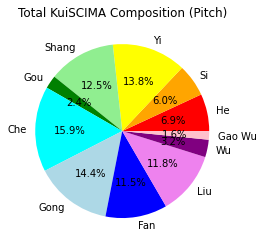

In [139]:
def visualize_simple(dataset):
    
    labels = "He", "Si", "Yi", "Shang", "Gou", "Che", "Gong", "Fan", "Liu", "Wu", "Gao Wu"
    sizes = []

    simple_list = np.array([entry['annotation']["pitch"] for entry in dataset])

    for idx in range(11):
        sizes.append(np.sum(simple_list == idx))
    plt.title("Total KuiSCIMA Composition (Pitch)")
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=["red", "orange", "yellow", "lightgreen", "green", "cyan", "lightblue", "blue", "violet", "purple", "pink"])
    plt.savefig("dataset_composition_simple.pdf", format="pdf", bbox_inches="tight")
visualize_simple(total_dataset)

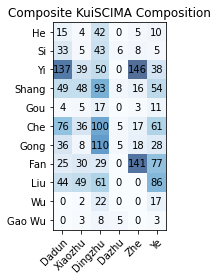

In [426]:
def visualize_composite(dataset):    

    simple_annotation = ["He", "Si", "Yi", "Shang", "Gou", "Che", "Gong", "Fan", "Liu", "Wu", "Gao Wu"]
    composite_annotation = ["Dadun", "Xiaozhu", "Dingzhu", "Dazhu", "Zhe", "Ye"]

    data = []
    indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
    for index in indices:
        temp = []
        for i in range(1,7):
            temp.append(len([entry for entry in dataset if(entry['annotation']["pitch"] == index and entry['annotation']["secondary"] == i)]))
        #check if temp is all zeros
        if (np.any(temp)):
            data.append(temp)

    fig, ax = plt.subplots()
    im = ax.imshow(data, cmap='Blues', alpha=0.7)

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(composite_annotation)), labels=composite_annotation)
    ax.set_yticks(np.arange(len(simple_annotation)), labels=simple_annotation)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(simple_annotation)):
        for j in range(len(composite_annotation)):
            text = ax.text(j, i, data[i][j], ha="center", va="center", color="black")

    ax.set_title("Composite KuiSCIMA Composition")
    fig.tight_layout()
    plt.show()
    fig.savefig("dataset_composition_composite.pdf", format="pdf", bbox_inches="tight")
    
    
visualize_composite(total_dataset)

In [405]:
import pickle
with open('model_stats.pkl', 'rb') as handle:
    model_dict = pickle.load(handle)
print(model_dict)

{'none': {'pitch_balanced': [{'epoch': 8, 'val_accuracy': tensor(0.9293)}, {'epoch': 10, 'val_accuracy': tensor(0.9293)}, {'epoch': 14, 'val_accuracy': tensor(0.9231)}, {'epoch': 13, 'val_accuracy': tensor(0.9275)}, {'epoch': 10, 'val_accuracy': tensor(0.9301)}], 'secondary_balanced': [{'epoch': 2, 'val_accuracy': tensor(0.9266)}, {'epoch': 14, 'val_accuracy': tensor(0.9223)}, {'epoch': 8, 'val_accuracy': tensor(0.9066)}, {'epoch': 2, 'val_accuracy': tensor(0.9066)}, {'epoch': 4, 'val_accuracy': tensor(0.9170)}]}, 'lu': {'pitch_balanced': [{'epoch': 7, 'val_accuracy': tensor(0.9588)}, {'epoch': 2, 'val_accuracy': tensor(0.9504)}, {'epoch': 1, 'val_accuracy': tensor(0.9483)}, {'epoch': 1, 'val_accuracy': tensor(0.9553)}, {'epoch': 14, 'val_accuracy': tensor(0.9483)}], 'secondary_balanced': [{'epoch': 6, 'val_accuracy': tensor(0.9246)}, {'epoch': 13, 'val_accuracy': tensor(0.9239)}, {'epoch': 11, 'val_accuracy': tensor(0.9323)}, {'epoch': 1, 'val_accuracy': tensor(0.9406)}, {'epoch': 10,

In [407]:
# Testing single models
test_model_dict = {}

for val_edition in dataclasses.astuple(ValidationEditions()):
    test_model_dict[val_edition] = {}
    for label_type in dataclasses.astuple(LabelType()):
        cur_models = model_dict[val_edition][label_type]
        
        best_accuracy = 0
        best_idx = 0
        for idx in range(len(cur_models)):
            if cur_models[idx]["val_accuracy"] > best_accuracy:
                best_accuracy = cur_models[idx]["val_accuracy"]
                best_idx = idx
        
        model = FashionCNN(num_output_classes = 11 if "pitch" in label_type else 7)
        model.load_state_dict(torch.load(f"{val_edition}-{label_type}-{best_idx}.std", map_location=torch.device('cpu')))
        test_model_dict[val_edition][label_type] = float(test(model, test_dataloaders[label_type], label_type)[0])
        
print(test_model_dict)

Testing with
pitch_balanced
    Acc.(Total): 93.68%, Acc.(Simple): 97.76%, Acc.(Composite): 83.57%
Testing with
secondary_balanced
    Acc.(Total): 92.36%, Acc.(Simple): 94.93%, Acc.(Composite): 85.99%
Testing with
pitch_balanced
    Acc.(Total): 93.06%, Acc.(Simple): 97.37%, Acc.(Composite): 82.37%
Testing with
secondary_balanced
    Acc.(Total): 93.40%, Acc.(Simple): 96.88%, Acc.(Composite): 84.78%
Testing with
pitch_balanced
    Acc.(Total): 93.68%, Acc.(Simple): 97.95%, Acc.(Composite): 83.09%
Testing with
secondary_balanced
    Acc.(Total): 92.85%, Acc.(Simple): 96.78%, Acc.(Composite): 83.09%
Testing with
pitch_balanced
    Acc.(Total): 93.19%, Acc.(Simple): 97.56%, Acc.(Composite): 82.37%
Testing with
secondary_balanced
    Acc.(Total): 93.75%, Acc.(Simple): 95.61%, Acc.(Composite): 89.13%
Testing with
pitch_balanced
    Acc.(Total): 94.86%, Acc.(Simple): 98.34%, Acc.(Composite): 86.23%
Testing with
secondary_balanced
    Acc.(Total): 88.47%, Acc.(Simple): 88.69%, Acc.(Composite

In [419]:
# Testing composite models, i.e. different pitch and secondary models together and calculating the symbol-level accuracy rate

composite_test_dict = {}

def get_best_models(label_type):
    best_models = []
    for trained_edition in dataclasses.astuple(ValidationEditions()):
        cur_models = model_dict[trained_edition][label_type]
        best_accuracy = 0
        best_idx = 0
        for idx in range(len(cur_models)):
            if cur_models[idx]["val_accuracy"] > best_accuracy:
                best_accuracy = cur_models[idx]["val_accuracy"]
                best_idx = idx
                
        model = FashionCNN(num_output_classes = 11 if label_type == LabelType.PITCH_BALANCED else 7)
        model.load_state_dict(torch.load(f"{trained_edition}-{label_type}-{best_idx}.std", map_location=torch.device('cpu'))) 
        best_models.append(model)
    return best_models
        
pitch_models = get_best_models(LabelType.PITCH_BALANCED)
secondary_models = get_best_models(LabelType.SECONDARY_BALANCED)
    
composite_test_dict = torch.Tensor(len(dataclasses.astuple(ValidationEditions())), len(dataclasses.astuple(ValidationEditions())))

l = range(len(dataclasses.astuple(ValidationEditions())))
for pitch_edition in l:
    for secondary_edition in l:
        best_pitch = pitch_models[pitch_edition]
        best_secondary = secondary_models[secondary_edition]
        
        _, pred_pitch, true_pitch = test(best_pitch, test_dataloaders[LabelType.PITCH_BALANCED], LabelType.PITCH_BALANCED)
        _, pred_secondary, true_secondary = test(best_secondary, test_dataloaders[LabelType.SECONDARY_BALANCED], LabelType.SECONDARY_BALANCED)
        
        correct_list = []
        for idx in range(len(pred_pitch)):
            correct_list.append(pred_pitch[idx]==true_pitch[idx] and pred_secondary[idx]==true_secondary[idx])
        
        composite_test_dict[pitch_edition][secondary_edition] = np.mean(correct_list)
             
print(composite_test_dict)

Testing with
pitch_balanced
    Acc.(Total): 93.68%, Acc.(Simple): 97.76%, Acc.(Composite): 83.57%
Testing with
secondary_balanced
    Acc.(Total): 92.36%, Acc.(Simple): 94.93%, Acc.(Composite): 85.99%
Testing with
pitch_balanced
    Acc.(Total): 93.68%, Acc.(Simple): 97.76%, Acc.(Composite): 83.57%
Testing with
secondary_balanced
    Acc.(Total): 93.40%, Acc.(Simple): 96.88%, Acc.(Composite): 84.78%
Testing with
pitch_balanced
    Acc.(Total): 93.68%, Acc.(Simple): 97.76%, Acc.(Composite): 83.57%
Testing with
secondary_balanced
    Acc.(Total): 92.85%, Acc.(Simple): 96.78%, Acc.(Composite): 83.09%
Testing with
pitch_balanced
    Acc.(Total): 93.68%, Acc.(Simple): 97.76%, Acc.(Composite): 83.57%
Testing with
secondary_balanced
    Acc.(Total): 93.75%, Acc.(Simple): 95.61%, Acc.(Composite): 89.13%
Testing with
pitch_balanced
    Acc.(Total): 93.68%, Acc.(Simple): 97.76%, Acc.(Composite): 83.57%
Testing with
secondary_balanced
    Acc.(Total): 88.47%, Acc.(Simple): 88.69%, Acc.(Composite

In [144]:
def get_means_and_confidences(label_type):
    means = []
    confidence_span = []
    for val_edition in dataclasses.astuple(ValidationEditions()):
        val_list = [data["val_accuracy"] for data in model_dict[val_edition][label_type]]
        means.append(np.mean(val_list))
        confidence_span.append(1.96 * np.std(val_list)/np.sqrt(len(val_list)))
    return means, confidence_span

def get_test_accs(test_dict, label_type):
    accs = []
    for val_edition in dataclasses.astuple(ValidationEditions()):
        acc = test_dict[val_edition][label_type]
        accs.append(acc)
    return accs

[0.92786026, 0.9522346, 0.9174492, 0.940612, 0.9159075]
[0.91580784, 0.92960894, 0.9058164, 0.9132128, 0.89572537]


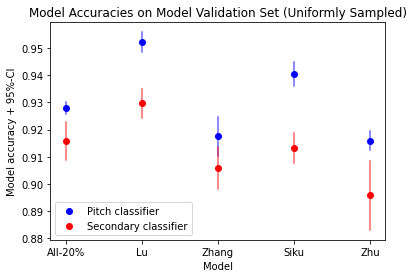

In [154]:
means_pitch, confidence_pitch = get_means_and_confidences(LabelType.PITCH_BALANCED)
means_secondary, confidence_secondary = get_means_and_confidences(LabelType.SECONDARY_BALANCED)

xs = np.array(range(len(means_pitch)))
labels = ["All-20%", "Lu", "Zhang", "Siku", "Zhu"]
offset = 0

plt.scatter(xs-offset, means_pitch, c="blue")
plt.scatter(xs+offset, means_secondary, c="red")
plt.xticks(xs, labels)

plt.title("Model Accuracies on Model Validation Set (Uniformly Sampled)")

print(means_pitch)
print(means_secondary)

plt.ylabel("Model accuracy + 95%-CI")
plt.xlabel("Model")
plt.legend(["Pitch classifier", "Secondary classifier"], loc='lower left')

for idx in range(len(means_pitch)):
    plt.plot((xs[idx]-offset, xs[idx]-offset),(means_pitch[idx]-confidence_pitch[idx], means_pitch[idx]+confidence_pitch[idx]),color='blue', alpha=.6)
    plt.plot((xs[idx]+offset, xs[idx]+offset),(means_secondary[idx]-confidence_secondary[idx], means_secondary[idx]+confidence_secondary[idx]),color='red', alpha=.6)
plt.savefig("validation_accuracies.pdf", format="pdf", bbox_inches="tight")

[0.9368055462837219, 0.9305555820465088, 0.9368055462837219, 0.9319444298744202, 0.9486111402511597]
[0.9236111044883728, 0.9340277910232544, 0.9284722208976746, 0.9375, 0.8847222328186035]


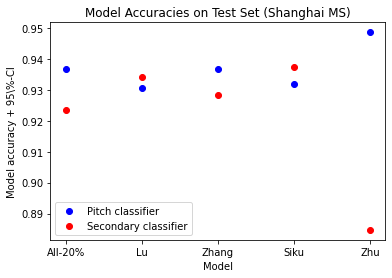

In [455]:
test_pitch = get_test_accs(test_model_dict, LabelType.PITCH_BALANCED)
test_secondary = get_test_accs(test_model_dict, LabelType.SECONDARY_BALANCED)

plt.scatter(xs, test_pitch, c="blue")
plt.scatter(xs, test_secondary, c="red")

plt.ylabel("Model accuracy + 95\%-CI")
plt.xlabel("Model")
plt.title("Model Accuracies on Test Set (Shanghai MS)")
plt.xticks(xs, labels)
plt.legend(["Pitch classifier", "Secondary classifier"], loc='lower left')
plt.savefig("test_accuracies.pdf", format="pdf", bbox_inches="tight")

print(test_pitch)
print(test_secondary)

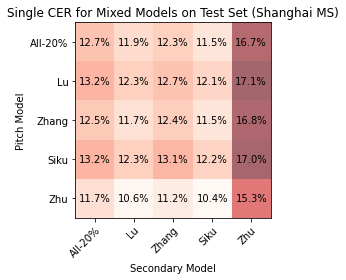

tensor(0.1667)
tensor(0.1708)


In [451]:
# CER for all mixed classifiers

data = torch.Tensor(composite_test_dict)
fig, ax = plt.subplots()
im = ax.imshow(1-composite_test_dict, cmap='Reds', alpha=.6)

# Show all ticks and label them with the respective list entries
ax.set_xticks(xs, labels=labels)
ax.set_yticks(xs, labels=labels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.xlabel("Secondary Model")
plt.ylabel("Pitch Model")

# Loop over data dimensions and create text annotations.
for i in range(len(labels)):
    for j in range(len(labels)):
        text = ax.text(j, i, f"{100-composite_test_dict[i][j]*100:.1f}%", ha="center", va="center", color="black")

ax.set_title("Single CER for Mixed Models on Test Set (Shanghai MS)")
fig.tight_layout()
plt.show()
fig.savefig("cer.pdf", format="pdf", bbox_inches="tight")

print(1-composite_test_dict[0][-1])
print(1-composite_test_dict[1][-1])